In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ROOT as root
from math import *
import array as array

Welcome to JupyROOT 6.20/06


In [2]:

f_ttV = root.TFile.Open("output_mc16e/ttV.root","read")
f_W = root.TFile.Open("output_mc16e/Wjets.root","read")
f_Z = root.TFile.Open("output_mc16e/Zjets.root","read")
f_tt = root.TFile.Open("output_mc16e/ttbar.root","read")
f_di = root.TFile.Open("output_mc16e/diboson.root","read")
f_si = root.TFile.Open("output_mc16e/singleTop.root","read")
f_data = root.TFile.Open("output_mc16e/data.root","read")

In [3]:
def getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, pt_limit):
    m_down = root.TLorentzVector()
    min_deltaM = 999999.0
    for jet in jets:
        if (jet == m_had_b or jet == m_cjet or jet == m_lep_b):
            continue
        temp = jet + m_cjet + m_had_b

        if (min_deltaM > fabs(m_mTop - temp.M())):
            min_deltaM = fabs(m_mTop - temp.M())
            m_down = jet
            
    dpt = fabs(m_down.Pt())

    if (dpt == 0):
        m_down = 0
        return m_down

    return m_down

#try cut jets on pt first

In [4]:
def getNeutrino(m_mW, m_lepton, m_met_x, m_met_y):
    
    k = ((m_mW*m_mW - m_lepton.M()*m_lepton.M()) / 2.) + (m_lepton.Px()*m_met_x + m_lepton.Py()*m_met_y)
    a = m_lepton.E()*m_lepton.E() - m_lepton.Pz()*m_lepton.Pz()
    b = -2 * k * m_lepton.Pz()
    c = m_lepton.E()*m_lepton.E()*met_met*met_met - k*k

    disc = b*b - 4*a*c
    nu_pz = 0.0
    if (disc < 0):
        nu_pz = -b/(2*a)
    else:
        nu_pz_1 = (-b + np.sqrt(disc)) / (2*a)
        nu_pz_2 = (-b - np.sqrt(disc)) / (2*a)
        
        nu_pz = nu_pz_1 if (fabs(nu_pz_1) > fabs(nu_pz_2)) else nu_pz_2

    if (nu_pz == 0.0):        
        print("Failed to reconstruct nu")

    energy = np.sqrt(m_met_x*m_met_x + m_met_y*m_met_y + nu_pz*nu_pz)
    m_neutrino = root.TLorentzVector()
    m_neutrino.SetPxPyPzE(m_met_x, m_met_y, nu_pz, energy)

    return m_neutrino;

In [5]:
def getBJets(jets, m_bjet_PCB, pcbs, m_bjets):
#    m_bjets.clear()
    n_jets = len(jets)
    for ijet in range(0, n_jets):
        tjet = jets[ijet]       
        if (pcbs[ijet] >= m_bjet_PCB):
            m_bjets.append(tjet)
    return m_bjets

In [6]:
def getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets):
#    m_cjets.clear()
    n_jets = len(jets)
    for ijet in range(0, n_jets):
        tjet = jets[ijet]
        if (pcbs[ijet] >= m_cjet_PCB and pcbs[ijet] < m_bjet_PCB):
            m_cjets.append(tjet)
    return m_cjets

In [7]:
def getLeptonicBJet(m_lepton, m_bjets):
    min_dR = 999.0
    m_lep_b = root.TLorentzVector()
    for bjet in m_bjets:
        dR = bjet.DeltaR(m_lepton)
        if (min_dR > dR):
            min_dR = dR
            m_lep_b = bjet
    return m_lep_b

In [8]:
def getHadronicBJet(m_bjets):
    for bjet in m_bjets:
        if (m_lep_b == bjet):
            continue
        m_had_b = bjet;
        return bjet;        
    print ("ERROR: Unable to find a hadronic bjet, returning the lead jet")       
    return m_bjets[0];

In [9]:
file = root.TFile("selection_mc16e_strict.root", 'recreate')
newtree = root.TTree("selection", "selection")

mdown = root.TLorentzVector()
mhadtop = root.TLorentzVector()
mleptop = root.TLorentzVector()
mttbar = root.TLorentzVector()

deltaphi  = array.array('d',[0])
numjets = array.array('i',[0])
mET  = array.array('d',[0])
settype = array.array('i',[0])
event_weight = array.array('d',[0])

downpt  = array.array('d',[0])
downeta  = array.array('d',[0])
downphi  = array.array('d',[0])
downm  = array.array('d',[0])

hadtoppt  = array.array('d',[0])
hadtopeta  = array.array('d',[0])
hadtopphi  = array.array('d',[0])
hadtopm  = array.array('d',[0])

leptoppt  = array.array('d',[0])
leptopeta  = array.array('d',[0])
leptopphi  = array.array('d',[0])
leptopm  = array.array('d',[0])

tt_pt  = array.array('d',[0])
tt_eta  = array.array('d',[0])
tt_phi  = array.array('d',[0])
tt_m  = array.array('d',[0])

m_met  = array.array('d',[0])
m_phi  = array.array('d',[0])

newtree.Branch("m_down",  mdown,  "TLorentzVector")
newtree.Branch("m_hadtop", mhadtop, "TLorentzVector")
newtree.Branch("m_leptop", mleptop, "TLorentzVector")
newtree.Branch("m_ttbar", mttbar, "TLorentzVector")

newtree.Branch("delta_phi",  deltaphi,  'delta_phi/D')

newtree.Branch("down_pt",  downpt,  'down_pt/D')
newtree.Branch("down_eta",  downeta,  'down_eta/D')
newtree.Branch("down_phi",  downphi,  'down_phi/D')
newtree.Branch("down_m",  downm,  'down_m/D')

newtree.Branch("hadtop_pt",  hadtoppt,  'hadtop_pt/D')
newtree.Branch("hadtop_eta",  hadtopeta,  'hadtop_eta/D')
newtree.Branch("hadtop_phi",  hadtopphi,  'hadtop_phi/D')
newtree.Branch("hadtop_m",  hadtopm,  'hadtop_m/D')

newtree.Branch("leptop_pt",  leptoppt,  'leptop_pt/D')
newtree.Branch("leptop_eta",  leptopeta,  'leptop_eta/D')
newtree.Branch("leptop_phi",  leptopphi,  'leptop_phi/D')
newtree.Branch("leptop_m",  leptopm,  'leptop_m/D')

newtree.Branch("tt_pt",  tt_pt,  'tt_pt/D')
newtree.Branch("tt_eta",  tt_eta,  'tt_eta/D')
newtree.Branch("tt_phi",  tt_phi,  'tt_phi/D')
newtree.Branch("tt_m",  tt_m,  'tt_m/D')

newtree.Branch("n_jets", numjets, 'n_jets/I')
newtree.Branch("m_met",  m_met,  'm_met/D')
newtree.Branch("m_phi",  m_phi,  'm_phi/D')
newtree.Branch("settype", settype, 'settype/I')
newtree.Branch("event_weight", event_weight, 'event_weight/D')




#settype = 1 (ttV)
#settype = 2 (W)
#settype = 3 (Z)
#settype = 4 (ttbar)
#settype = 5 (diboson)
#settype = 6 (single top)
#settype = 7 (data)

<ROOT.TBranch object ("event_weight") at 0x74a41a0>

In [9]:
index_fail = 0
Custom_bins = np.array((0.,10000.,20000.,30000.,40000.,50000.,60000.,70000.,80000.,90000.,100000.,115000.,130000.,145000.,160000.,200000.,250000.,500000.))
N = len(Custom_bins)-1

In [11]:
tree = f_ttV.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

#h_ttV = root.TH1D("ttV","down_pt",N,Custom_bins)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    #if (event.down_index >= njets):
        #continue
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    pt_limit = 35*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event

        if (event.jet_pt[ijet] <= pt_limit):
            continue
        
        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    if (len(jets) < 4):
        continue
    
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    if (len(m_bjets) != 2):
        continue
    
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (len(m_cjets) != 1):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    

    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)

    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, pt_limit)
    

    if (m_down == []):
        continue
        
    if (m_down == 0):
        index_fail += event.event_weight
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    

    m_ttbar = m_hadtop + m_leptop
    
    down_pt = m_down.Pt()
    
#    h_ttV.Fill(down_pt, event.event_weight)
    
    mdown.SetPtEtaPhiM(down_pt,m_down.Eta(),m_down.Phi(),m_down.M())
    mhadtop.SetPtEtaPhiM(m_hadtop.Pt(),m_hadtop.Eta(),m_hadtop.Phi(),m_hadtop.M())
    mleptop.SetPtEtaPhiM(m_leptop.Pt(),m_leptop.Eta(),m_leptop.Phi(),m_leptop.M())
    
    downpt[0] = down_pt
    downeta[0] = m_down.Eta()
    downphi[0] = m_down.Phi()
    downm[0] = m_down.M()

    hadtoppt[0] = m_hadtop.Pt()
    hadtopeta[0] = m_hadtop.Eta()
    hadtopphi[0] = m_hadtop.Phi()
    hadtopm[0] = m_hadtop.M()

    leptoppt[0] = m_leptop.Pt()
    leptopeta[0] = m_leptop.Eta()
    leptopphi[0] = m_leptop.Phi()
    leptopm[0] = m_leptop.M()

    tt_pt[0] = m_ttbar.Pt()
    tt_eta[0] = m_ttbar.Eta()
    tt_phi[0] = m_ttbar.Phi()
    tt_m[0] = m_ttbar.M()
    
    m_met[0]  = met_met
    m_phi[0]  = met_phi
    
    deltaphi[0] = m_down.DeltaPhi(m_lepton)
    numjets[0] = njets
    settype[0] = 1
    event_weight[0] = event.event_weight
    
    
    newtree.Fill()


In [12]:
tree = f_W.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

#h_W = root.TH1D("Wjets","down_pt",N,Custom_bins)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    #if (event.down_index >= njets):
        #continue
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event
        
        if (event.jet_pt[ijet] <= pt_limit):
            continue

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    if (len(jets) < 4):
        continue
    
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    if (len(m_bjets) != 2):
        continue
    
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (len(m_cjets) != 1):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)
    
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    

    if (m_down == []):
        continue
        
    if (m_down == 0):
        index_fail += event.event_weight
        continue       

    m_hadtop = m_down + m_had_b + m_cjet
    


    m_ttbar = m_hadtop + m_leptop
    
    down_pt = m_down.Pt()
    
#    h_W.Fill(down_pt, event.event_weight)

    mdown.SetPtEtaPhiM(down_pt,m_down.Eta(),m_down.Phi(),m_down.M())
    mhadtop.SetPtEtaPhiM(m_hadtop.Pt(),m_hadtop.Eta(),m_hadtop.Phi(),m_hadtop.M())
    mleptop.SetPtEtaPhiM(m_leptop.Pt(),m_leptop.Eta(),m_leptop.Phi(),m_leptop.M())
    
    downpt[0] = down_pt
    downeta[0] = m_down.Eta()
    downphi[0] = m_down.Phi()
    downm[0] = m_down.M()

    hadtoppt[0] = m_hadtop.Pt()
    hadtopeta[0] = m_hadtop.Eta()
    hadtopphi[0] = m_hadtop.Phi()
    hadtopm[0] = m_hadtop.M()

    leptoppt[0] = m_leptop.Pt()
    leptopeta[0] = m_leptop.Eta()
    leptopphi[0] = m_leptop.Phi()
    leptopm[0] = m_leptop.M()

    tt_pt[0] = m_ttbar.Pt()
    tt_eta[0] = m_ttbar.Eta()
    tt_phi[0] = m_ttbar.Phi()
    tt_m[0] = m_ttbar.M()
    
    m_met[0]  = met_met
    m_phi[0]  = met_phi
    
    deltaphi[0] = m_down.DeltaPhi(m_lepton)
    numjets[0] = njets
    settype[0] = 2
    event_weight[0] = event.event_weight
    
    
    newtree.Fill()

         

In [13]:
tree = f_Z.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

#h_Z = root.TH1D("Z","down_pt",N,Custom_bins)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    #if (event.down_index >= njets):
        #continue
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event

        if (event.jet_pt[ijet] <= pt_limit):
            continue        
        
        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    if (len(jets) < 4):
        continue
    
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    if (len(m_bjets) != 2):
        continue
    
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (len(m_cjets) != 1):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)    
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
   

    if (m_down == []):
        continue
        
    if (m_down == 0):
        index_fail += event.event_weight
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    
    m_ttbar = m_hadtop + m_leptop
    
    down_pt = m_down.Pt()
    
#    h_Z.Fill(down_pt,event.event_weight)

    mdown.SetPtEtaPhiM(down_pt,m_down.Eta(),m_down.Phi(),m_down.M())
    mhadtop.SetPtEtaPhiM(m_hadtop.Pt(),m_hadtop.Eta(),m_hadtop.Phi(),m_hadtop.M())
    mleptop.SetPtEtaPhiM(m_leptop.Pt(),m_leptop.Eta(),m_leptop.Phi(),m_leptop.M())
    
    downpt[0] = down_pt
    downeta[0] = m_down.Eta()
    downphi[0] = m_down.Phi()
    downm[0] = m_down.M()

    hadtoppt[0] = m_hadtop.Pt()
    hadtopeta[0] = m_hadtop.Eta()
    hadtopphi[0] = m_hadtop.Phi()
    hadtopm[0] = m_hadtop.M()

    leptoppt[0] = m_leptop.Pt()
    leptopeta[0] = m_leptop.Eta()
    leptopphi[0] = m_leptop.Phi()
    leptopm[0] = m_leptop.M()

    tt_pt[0] = m_ttbar.Pt()
    tt_eta[0] = m_ttbar.Eta()
    tt_phi[0] = m_ttbar.Phi()
    tt_m[0] = m_ttbar.M()
    
    m_met[0]  = met_met
    m_phi[0]  = met_phi
    
    deltaphi[0] = m_down.DeltaPhi(m_lepton)
    numjets[0] = njets
    settype[0] = 3
    event_weight[0] = event.event_weight
    
    
    newtree.Fill()
    


In [11]:
tree = f_tt.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)


#h_tt = root.TH1D("ttbar","down_pt",N,Custom_bins)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    #if (event.down_index >= njets):
        #continue
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    pt_limit = 35*GeV
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event
        
        if (event.jet_pt[ijet] <= pt_limit):
            continue     

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    if (len(jets) < 4):
        continue
    
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    if (len(m_bjets) != 2):
        continue
    
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (len(m_cjets) != 1):
        continue
    
    m_cjet = m_cjets[0]
    

    
    m_had_b = getHadronicBJet(m_bjets)
    
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)
    
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    


    if (m_down == []):
        continue
        
    if (m_down == 0):
        index_fail += event.event_weight
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    
    index2 += event.event_weight
    

    m_ttbar = m_hadtop + m_leptop
    
    down_pt = m_down.Pt()
    
    real_down_pt = event.jet_pt[event.down_index]
    
    if (real_down_pt == down_pt):
        index3 += event.event_weight
    
#    h_tt.Fill(down_pt,event.event_weight)

    mdown.SetPtEtaPhiM(down_pt,m_down.Eta(),m_down.Phi(),m_down.M())
    mhadtop.SetPtEtaPhiM(m_hadtop.Pt(),m_hadtop.Eta(),m_hadtop.Phi(),m_hadtop.M())
    mleptop.SetPtEtaPhiM(m_leptop.Pt(),m_leptop.Eta(),m_leptop.Phi(),m_leptop.M())
    
    downpt[0] = down_pt
    downeta[0] = m_down.Eta()
    downphi[0] = m_down.Phi()
    downm[0] = m_down.M()

    hadtoppt[0] = m_hadtop.Pt()
    hadtopeta[0] = m_hadtop.Eta()
    hadtopphi[0] = m_hadtop.Phi()
    hadtopm[0] = m_hadtop.M()

    leptoppt[0] = m_leptop.Pt()
    leptopeta[0] = m_leptop.Eta()
    leptopphi[0] = m_leptop.Phi()
    leptopm[0] = m_leptop.M()

    tt_pt[0] = m_ttbar.Pt()
    tt_eta[0] = m_ttbar.Eta()
    tt_phi[0] = m_ttbar.Phi()
    tt_m[0] = m_ttbar.M()
    
    m_met[0]  = met_met
    m_phi[0]  = met_phi
    
    deltaphi[0] = m_down.DeltaPhi(m_lepton)
    numjets[0] = njets
    settype[0] = 4
    event_weight[0] = event.event_weight
    
    
    newtree.Fill()


    
print((index3/index2)*100)


    

63.91659790765103


In [15]:
tree = f_di.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

#h_di = root.TH1D("diboson","down_pt",N,Custom_bins)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    #if (event.down_index >= njets):
        #continue
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event
        
        if (event.jet_pt[ijet] <= pt_limit):
            continue 

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    if (len(jets) < 4):
        continue
    
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    if (len(m_bjets) != 2):
        continue
    
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (len(m_cjets) != 1):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    


    if (m_down == []):
        continue
        
    if (m_down == 0):
        index_fail += event.event_weight
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    


    m_ttbar = m_hadtop + m_leptop
    
    down_pt = m_down.Pt()
    
#    h_di.Fill(down_pt,event.event_weight)

    mdown.SetPtEtaPhiM(down_pt,m_down.Eta(),m_down.Phi(),m_down.M())
    mhadtop.SetPtEtaPhiM(m_hadtop.Pt(),m_hadtop.Eta(),m_hadtop.Phi(),m_hadtop.M())
    mleptop.SetPtEtaPhiM(m_leptop.Pt(),m_leptop.Eta(),m_leptop.Phi(),m_leptop.M())
    
    downpt[0] = down_pt
    downeta[0] = m_down.Eta()
    downphi[0] = m_down.Phi()
    downm[0] = m_down.M()

    hadtoppt[0] = m_hadtop.Pt()
    hadtopeta[0] = m_hadtop.Eta()
    hadtopphi[0] = m_hadtop.Phi()
    hadtopm[0] = m_hadtop.M()

    leptoppt[0] = m_leptop.Pt()
    leptopeta[0] = m_leptop.Eta()
    leptopphi[0] = m_leptop.Phi()
    leptopm[0] = m_leptop.M()

    tt_pt[0] = m_ttbar.Pt()
    tt_eta[0] = m_ttbar.Eta()
    tt_phi[0] = m_ttbar.Phi()
    tt_m[0] = m_ttbar.M()
    
    m_met[0]  = met_met
    m_phi[0]  = met_phi
    
    deltaphi[0] = m_down.DeltaPhi(m_lepton)
    numjets[0] = njets
    settype[0] = 5
    event_weight[0] = event.event_weight
    
    
    newtree.Fill()


    

In [16]:
tree = f_si.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

#h_si = root.TH1D("singleTop","down_pt",N,Custom_bins)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    #if (event.down_index >= njets):
        #continue
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event
        
        if (event.jet_pt[ijet] <= pt_limit):
            continue 

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    if (len(jets) < 4):
        continue
    
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    if (len(m_bjets) != 2):
        continue
    
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (len(m_cjets) != 1):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
 
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop) 
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    


    if (m_down == []):
        continue
    
    if (m_down == 0):
        index_fail += event.event_weight
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    


    m_ttbar = m_hadtop + m_leptop
    
    down_pt = m_down.Pt()
    
#    h_si.Fill(down_pt,event.event_weight)
    
    mdown.SetPtEtaPhiM(down_pt,m_down.Eta(),m_down.Phi(),m_down.M())
    mhadtop.SetPtEtaPhiM(m_hadtop.Pt(),m_hadtop.Eta(),m_hadtop.Phi(),m_hadtop.M())
    mleptop.SetPtEtaPhiM(m_leptop.Pt(),m_leptop.Eta(),m_leptop.Phi(),m_leptop.M())
    
    downpt[0] = down_pt
    downeta[0] = m_down.Eta()
    downphi[0] = m_down.Phi()
    downm[0] = m_down.M()

    hadtoppt[0] = m_hadtop.Pt()
    hadtopeta[0] = m_hadtop.Eta()
    hadtopphi[0] = m_hadtop.Phi()
    hadtopm[0] = m_hadtop.M()

    leptoppt[0] = m_leptop.Pt()
    leptopeta[0] = m_leptop.Eta()
    leptopphi[0] = m_leptop.Phi()
    leptopm[0] = m_leptop.M()

    tt_pt[0] = m_ttbar.Pt()
    tt_eta[0] = m_ttbar.Eta()
    tt_phi[0] = m_ttbar.Phi()
    tt_m[0] = m_ttbar.M()
    
    m_met[0]  = met_met
    m_phi[0]  = met_phi
    
    deltaphi[0] = m_down.DeltaPhi(m_lepton)
    numjets[0] = njets
    settype[0] = 6
    event_weight[0] = event.event_weight
    
    
    newtree.Fill()

    
print(index_fail)



451.34045131938416


In [17]:
tree = f_data.Get("nominal")

index = 0
index2 = 0
index3 = 0
index_fail_data = 0
listing = []
masses = np.array(listing)

#h_data = root.TH1D("data","down_pt",N,Custom_bins)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    #if (event.down_index >= njets):
        #continue
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event
        
        if (event.jet_pt[ijet] <= pt_limit):
            continue

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    if (len(jets) < 4):
        continue
    
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    if (len(m_bjets) != 2):
        continue
    
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (len(m_cjets) != 1):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop) 
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    


    if (m_down == []):
        continue
        
    if (m_down == 0):
        index_fail_data += event.event_weight
        continue

    m_hadtop = m_down + m_had_b + m_cjet

    m_ttbar = m_hadtop + m_leptop
    
    down_pt = m_down.Pt()
    
#    h_data.Fill(down_pt,event.event_weight)

    mdown.SetPtEtaPhiM(down_pt,m_down.Eta(),m_down.Phi(),m_down.M())
    mhadtop.SetPtEtaPhiM(m_hadtop.Pt(),m_hadtop.Eta(),m_hadtop.Phi(),m_hadtop.M())
    mleptop.SetPtEtaPhiM(m_leptop.Pt(),m_leptop.Eta(),m_leptop.Phi(),m_leptop.M())
    
    downpt[0] = down_pt
    downeta[0] = m_down.Eta()
    downphi[0] = m_down.Phi()
    downm[0] = m_down.M()

    hadtoppt[0] = m_hadtop.Pt()
    hadtopeta[0] = m_hadtop.Eta()
    hadtopphi[0] = m_hadtop.Phi()
    hadtopm[0] = m_hadtop.M()

    leptoppt[0] = m_leptop.Pt()
    leptopeta[0] = m_leptop.Eta()
    leptopphi[0] = m_leptop.Phi()
    leptopm[0] = m_leptop.M()

    tt_pt[0] = m_ttbar.Pt()
    tt_eta[0] = m_ttbar.Eta()
    tt_phi[0] = m_ttbar.Phi()
    tt_m[0] = m_ttbar.M()
    
    m_met[0]  = met_met
    m_phi[0]  = met_phi
    
    deltaphi[0] = m_down.DeltaPhi(m_lepton)
    numjets[0] = njets
    settype[0] = 7
    event_weight[0] = event.event_weight
    
    
    newtree.Fill()

    
print(index_fail_data)



436.0


In [18]:
file.Write()
file.Close()

f_ttV.Close()
f_W.Close()
f_Z.Close()
f_tt.Close()
f_di.Close()
f_si.Close()
f_data.Close()

Info in <TCanvas::Print>: png file njets_pt_selection_strict_mc16e.png has been created


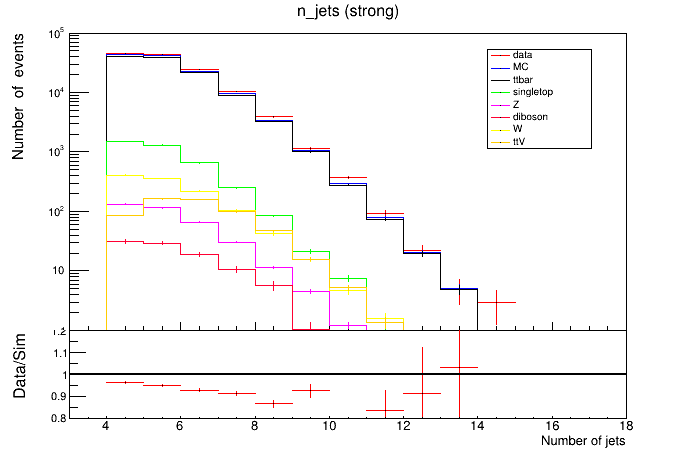

In [25]:
f_sel = root.TFile.Open("selection_mc16e_strict.root","read")
tree = f_sel.Get("selection")
can1 = root.TCanvas()


hist_data_n = root.TH1D("hist_data_n","n_jets (strong)",15,3,18)
hist_MC_n = root.TH1D("hist_MC_n","n_jets",15,3,18)
hist_n_ttbar = root.TH1D("hist_n_ttbar","n_jets",15,3,18)
hist_n_si = root.TH1D("hist_n_si","n_jets",15,3,18)
hist_n_Z = root.TH1D("hist_n_Z","n_jets",15,3,18)
hist_n_W = root.TH1D("hist_n_W","n_jets",15,3,18)
hist_n_di = root.TH1D("hist_n_di","n_jets",15,3,18)
hist_n_ttV = root.TH1D("hist_n_ttV","n_jets",15,3,18)

hist_MC_n.SetLineColor(root.kBlue)
hist_data_n.SetLineColor(root.kRed)
hist_n_ttbar.SetLineColor(root.kBlack)
hist_n_si.SetLineColor(root.kGreen)
hist_n_Z.SetLineColor(root.kMagenta)
hist_n_di.SetLineColor(root.kPink)
hist_n_W.SetLineColor(root.kYellow)
hist_n_ttV.SetLineColor(root.kOrange)

hist_MC_n.SetStats(0)
hist_data_n.SetStats(0)
hist_n_ttbar.SetStats(0)
hist_n_si.SetStats(0)
hist_n_Z.SetStats(0)
hist_n_di.SetStats(0)
hist_n_W.SetStats(0)
hist_n_ttV.SetStats(0)

pad1 = root.TPad("pad1","pad1" ,0,0.3,1,1)
pad1.SetLogy(True)
pad1.SetBottomMargin (0)
pad1.Draw()
pad1.cd()


tree.Draw("n_jets >> hist_data_n","(settype==7)*event_weight","pe")
tree.Draw("n_jets >> hist_MC_n","(settype!=7)*event_weight","h,same")
tree.Draw("n_jets >> hist_n_ttbar","(settype==4)*event_weight","h,same")
tree.Draw("n_jets >> hist_n_si","(settype==6)*event_weight","h,same")
tree.Draw("n_jets >> hist_n_Z","(settype==3)*event_weight","h,same")
tree.Draw("n_jets >> hist_n_di","(settype==5)*event_weight","h,same")
tree.Draw("n_jets >> hist_n_W","(settype==2)*event_weight","h,same")
tree.Draw("n_jets >> hist_n_ttV","(settype==1)*event_weight","h,same")

hist_data_n.GetYaxis (). SetTitleSize (0.05)
hist_data_n.GetYaxis().SetRangeUser (1 ,100000)
hist_data_n.GetYaxis().SetTitle("Number  of  events")

legend = root.TLegend(.7,.55,.85,.85)
legend.AddEntry(hist_data_n,"data");
legend.AddEntry(hist_MC_n,"MC");
legend.AddEntry(hist_n_ttbar,"ttbar");
legend.AddEntry(hist_n_si,"singletop");
legend.AddEntry(hist_n_Z,"Z");
legend.AddEntry(hist_n_di,"diboson");
legend.AddEntry(hist_n_W,"W");
legend.AddEntry(hist_n_ttV,"ttV");

legend.Draw()

ratio = hist_MC_n.Clone()
ratio.Divide(hist_data_n)
ratio.SetLineColor(root.kRed)

can1.cd()
pad2 = root.TPad("pad2","pad2" ,0,0.05,1,0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad2.cd()
ratio.Draw("pe")
ratio.GetYaxis().SetRangeUser (0.8 ,1.2)
ratio.GetYaxis().SetNdivisions(207)
ratio.SetTitle("")
ratio.GetXaxis (). SetLabelSize (0.12)
ratio.GetXaxis (). SetTitleSize (0.12)
ratio.GetYaxis (). SetLabelSize (0.1)
ratio.GetYaxis (). SetTitleSize (0.15)
ratio.GetYaxis (). SetTitle("Data/Sim")
ratio.GetYaxis (). SetTitleOffset (0.3)
ratio.GetXaxis().SetTitle("Number of jets")

line = root.TLine (3 ,1 ,18 ,1)
line.SetLineColor(root.kBlack)
line.SetLineWidth (2)
line.Draw("same")


can1.Draw()

can1.Print("njets_pt_selection_strict_mc16e.png")

#settype = 1 (ttV)
#settype = 2 (W)
#settype = 3 (Z)
#settype = 4 (ttbar)
#settype = 5 (diboson)
#settype = 6 (single top)
#settype = 7 (data)

In [26]:
f_sel.Close()

Info in <TCanvas::Print>: png file downpt_pt_selection_strict_mc16e.png has been created


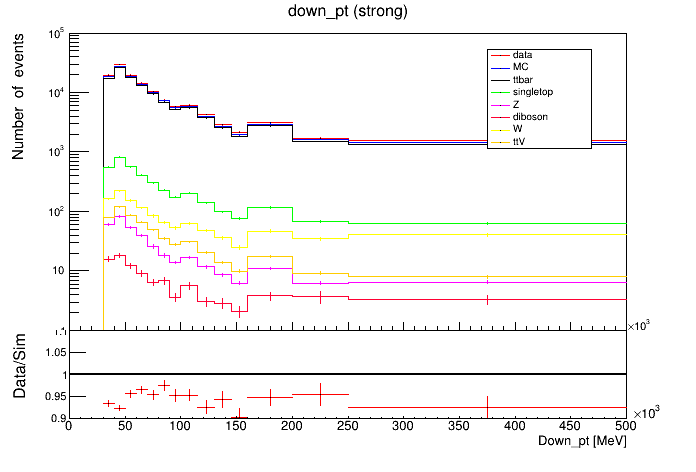

In [27]:
f_sel = root.TFile.Open("selection_mc16e_strict.root","read")
tree = f_sel.Get("selection")

can2 = root.TCanvas()
hist_data_down_pt = root.TH1D("hist_data_down_pt","down_pt (strong)",N,Custom_bins)
hist_MC_down_pt = root.TH1D("hist_MC_down_pt","downpt",N,Custom_bins)
hist_dpt_ttbar = root.TH1D("hist_dpt_ttbar","downpt",N,Custom_bins)
hist_dpt_si = root.TH1D("hist_dpt_si","downpt",N,Custom_bins)
hist_dpt_Z = root.TH1D("hist_dpt_Z","downpt",N,Custom_bins)
hist_dpt_W = root.TH1D("hist_dpt_W","downpt",N,Custom_bins)
hist_dpt_di = root.TH1D("hist_dpt_di","downpt",N,Custom_bins)
hist_dpt_ttV = root.TH1D("hist_dpt_ttV","downpt",N,Custom_bins)

hist_MC_down_pt.SetLineColor(root.kBlue)
hist_data_down_pt.SetLineColor(root.kRed)
hist_dpt_ttbar.SetLineColor(root.kBlack)
hist_dpt_si.SetLineColor(root.kGreen)
hist_dpt_Z.SetLineColor(root.kMagenta)
hist_dpt_di.SetLineColor(root.kPink)
hist_dpt_W.SetLineColor(root.kYellow)
hist_dpt_ttV.SetLineColor(root.kOrange)

hist_MC_down_pt.SetStats(0)
hist_data_down_pt.SetStats(0)
hist_dpt_ttbar.SetStats(0)
hist_dpt_si.SetStats(0)
hist_dpt_Z.SetStats(0)
hist_dpt_di.SetStats(0)
hist_dpt_W.SetStats(0)
hist_dpt_ttV.SetStats(0)

pad1 = root.TPad("pad1","pad1" ,0,0.3,1,1)
pad1.SetLogy(True)
pad1.SetBottomMargin (0)
pad1.Draw()
pad1.cd()


tree.Draw("down_pt >> hist_data_down_pt","(settype==7)*event_weight","pe")
tree.Draw("down_pt >> hist_MC_down_pt","(settype!=7)*event_weight","h,same")
tree.Draw("down_pt >> hist_dpt_ttbar","(settype==4)*event_weight","h,same")
tree.Draw("down_pt >> hist_dpt_si","(settype==6)*event_weight","h,same")
tree.Draw("down_pt >> hist_dpt_Z","(settype==3)*event_weight","h,same")
tree.Draw("down_pt >> hist_dpt_di","(settype==5)*event_weight","h,same")
tree.Draw("down_pt >> hist_dpt_W","(settype==2)*event_weight","h,same")
tree.Draw("down_pt >> hist_dpt_ttV","(settype==1)*event_weight","h,same")

hist_data_down_pt.GetYaxis (). SetTitleSize (0.05)
hist_data_down_pt.GetYaxis().SetRangeUser (1 ,100000)
hist_data_down_pt.GetYaxis().SetTitle("Number  of  events")

legend = root.TLegend(.7,.55,.85,.85)
legend.AddEntry(hist_data_down_pt,"data");
legend.AddEntry(hist_MC_down_pt,"MC");
legend.AddEntry(hist_dpt_ttbar,"ttbar");
legend.AddEntry(hist_dpt_si,"singletop");
legend.AddEntry(hist_dpt_Z,"Z");
legend.AddEntry(hist_dpt_di,"diboson");
legend.AddEntry(hist_dpt_W,"W");
legend.AddEntry(hist_dpt_ttV,"ttV");


legend.Draw()

ratio = hist_MC_down_pt.Clone()
ratio.Divide(hist_data_down_pt)
ratio.SetLineColor(root.kRed)

can2.cd()
pad2 = root.TPad("pad2","pad2" ,0,0.05,1,0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad2.cd()
ratio.Draw("pe")
ratio.GetYaxis().SetRangeUser (0.9 ,1.1)
ratio.GetYaxis().SetNdivisions(207)
ratio.SetTitle("")
ratio.GetXaxis (). SetLabelSize (0.12)
ratio.GetXaxis (). SetTitleSize (0.12)
ratio.GetYaxis (). SetLabelSize (0.1)
ratio.GetYaxis (). SetTitleSize (0.15)
ratio.GetYaxis (). SetTitle("Data/Sim")
ratio.GetYaxis (). SetTitleOffset (0.3)
ratio.GetXaxis().SetTitle("Down_pt [MeV]")

line = root.TLine (1.e3 ,1 ,500.e3 ,1)
line.SetLineColor(root.kBlack)
line.SetLineWidth (2)
line.Draw("same")


can2.Draw()

can2.Print("downpt_pt_selection_strict_mc16e.png")

#settype = 1 (ttV)
#settype = 2 (W)
#settype = 3 (Z)
#settype = 4 (ttbar)
#settype = 5 (diboson)
#settype = 6 (single top)
#settype = 7 (data)

In [28]:
f_sel.Close()

Info in <TCanvas::Print>: png file downm_pt_selection_strict_mc16e.png has been created


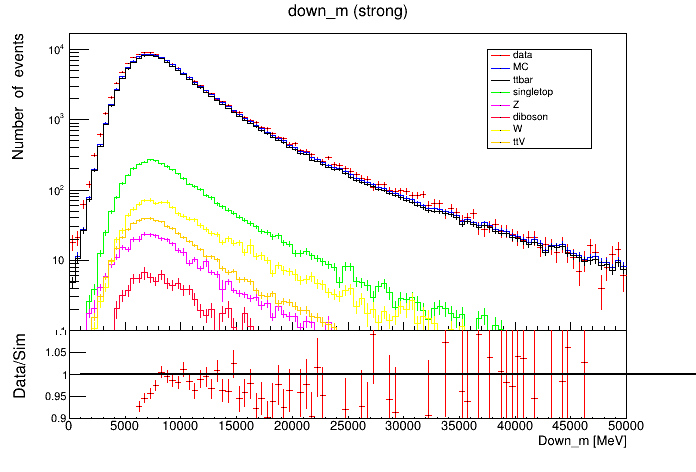

In [29]:
f_sel = root.TFile.Open("selection_mc16e_strict.root","read")
tree = f_sel.Get("selection")

can21 = root.TCanvas()
hist_data_down_m = root.TH1D("hist_data_down_m","down_m (strong)",100,0,50.e3)
hist_MC_down_m = root.TH1D("hist_MC_down_m","down_m",100,0,50.e3)
hist_dm_ttbar = root.TH1D("hist_dm_ttbar","down_m",100,0,50.e3)
hist_dm_si = root.TH1D("hist_dm_si","down_m",100,0,50.e3)
hist_dm_Z = root.TH1D("hist_dm_Z","down_m",100,0,50.e3)
hist_dm_W = root.TH1D("hist_dm_W","down_m",100,0,50.e3)
hist_dm_di = root.TH1D("hist_dm_di","down_m",100,0,50.e3)
hist_dm_ttV = root.TH1D("hist_dm_ttV","down_m",100,0,50.e3)

hist_MC_down_m.SetLineColor(root.kBlue)
hist_data_down_m.SetLineColor(root.kRed)
hist_dm_ttbar.SetLineColor(root.kBlack)
hist_dm_si.SetLineColor(root.kGreen)
hist_dm_Z.SetLineColor(root.kMagenta)
hist_dm_di.SetLineColor(root.kPink)
hist_dm_W.SetLineColor(root.kYellow)
hist_dm_ttV.SetLineColor(root.kOrange)

hist_MC_down_m.SetStats(0)
hist_data_down_m.SetStats(0)
hist_dm_ttbar.SetStats(0)
hist_dm_si.SetStats(0)
hist_dm_Z.SetStats(0)
hist_dm_di.SetStats(0)
hist_dm_W.SetStats(0)
hist_dm_ttV.SetStats(0)

pad1 = root.TPad("pad1","pad1" ,0,0.3,1,1)
pad1.SetLogy(True)
pad1.SetBottomMargin (0)
pad1.Draw()
pad1.cd()


tree.Draw("down_m >> hist_data_down_m","(settype==7)*event_weight","pe")
tree.Draw("down_m >> hist_MC_down_m","(settype!=7)*event_weight","h,same")
tree.Draw("down_m >> hist_dm_ttbar","(settype==4)*event_weight","h,same")
tree.Draw("down_m >> hist_dm_si","(settype==6)*event_weight","h,same")
tree.Draw("down_m >> hist_dm_Z","(settype==3)*event_weight","h,same")
tree.Draw("down_m >> hist_dm_di","(settype==5)*event_weight","h,same")
tree.Draw("down_m >> hist_dm_W","(settype==2)*event_weight","h,same")
tree.Draw("down_m >> hist_dm_ttV","(settype==1)*event_weight","h,same")

hist_data_down_m.GetYaxis (). SetTitleSize (0.05)
hist_data_down_m.GetYaxis().SetTitle("Number  of  events")

legend = root.TLegend(.7,.55,.85,.85)
legend.AddEntry(hist_data_down_m,"data");
legend.AddEntry(hist_MC_down_m,"MC");
legend.AddEntry(hist_dm_ttbar,"ttbar");
legend.AddEntry(hist_dm_si,"singletop");
legend.AddEntry(hist_dm_Z,"Z");
legend.AddEntry(hist_dm_di,"diboson");
legend.AddEntry(hist_dm_W,"W");
legend.AddEntry(hist_dm_ttV,"ttV");


legend.Draw()

ratio = hist_MC_down_m.Clone()
ratio.Divide(hist_data_down_m)
ratio.SetLineColor(root.kRed)

can21.cd()
pad2 = root.TPad("pad2","pad2" ,0,0.05,1,0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad2.cd()
ratio.Draw("pe")
ratio.GetYaxis().SetRangeUser (0.9 ,1.1)
ratio.GetYaxis().SetNdivisions(207)
ratio.SetTitle("")
ratio.GetXaxis (). SetLabelSize (0.12)
ratio.GetXaxis (). SetTitleSize (0.12)
ratio.GetYaxis (). SetLabelSize (0.1)
ratio.GetYaxis (). SetTitleSize (0.15)
ratio.GetYaxis (). SetTitle("Data/Sim")
ratio.GetYaxis (). SetTitleOffset (0.3)
ratio.GetXaxis().SetTitle("Down_m [MeV]")

line = root.TLine (1.e3 ,1 ,500.e3 ,1)
line.SetLineColor(root.kBlack)
line.SetLineWidth (2)
line.Draw("same")


can21.Draw()

can21.Print("downm_pt_selection_strict_mc16e.png")

#settype = 1 (ttV)
#settype = 2 (W)
#settype = 3 (Z)
#settype = 4 (ttbar)
#settype = 5 (diboson)
#settype = 6 (single top)
#settype = 7 (data)

In [24]:
f_sel.Close()

Info in <TCanvas::Print>: png file downphi_pt_selection_strict_mc16e.png has been created


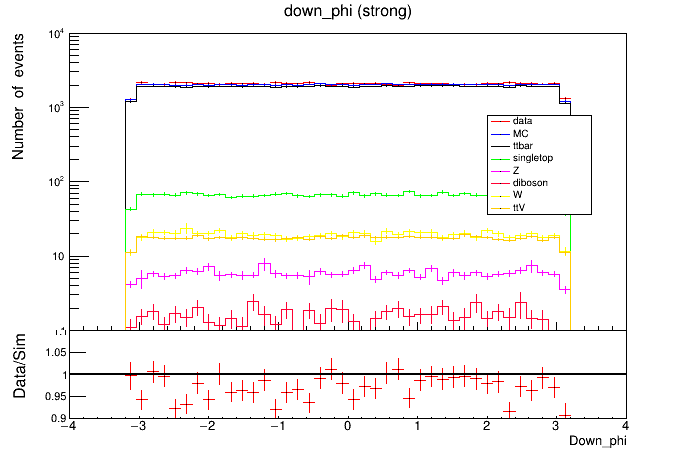

In [25]:
f_sel = root.TFile.Open("selection_mc16e_strict.root","read")
tree = f_sel.Get("selection")

can22 = root.TCanvas()
hist_data_down_phi = root.TH1D("hist_data_down_phi","down_phi (strong)",50,-4,4)
hist_MC_down_phi = root.TH1D("hist_MC_down_phi","down_phi",50,-4,4)
hist_dphi_ttbar = root.TH1D("hist_dphi_ttbar","down_phi",50,-4,4)
hist_dphi_si = root.TH1D("hist_dphi_si","down_phi",50,-4,4)
hist_dphi_Z = root.TH1D("hist_dphi_Z","down_phi",50,-4,4)
hist_dphi_W = root.TH1D("hist_dphi_W","down_phi",50,-4,4)
hist_dphi_di = root.TH1D("hist_dphi_di","down_phi",50,-4,4)
hist_dphi_ttV = root.TH1D("hist_dphi_ttV","down_phi",50,-4,4)

hist_MC_down_phi.SetLineColor(root.kBlue)
hist_data_down_phi.SetLineColor(root.kRed)
hist_dphi_ttbar.SetLineColor(root.kBlack)
hist_dphi_si.SetLineColor(root.kGreen)
hist_dphi_Z.SetLineColor(root.kMagenta)
hist_dphi_di.SetLineColor(root.kPink)
hist_dphi_W.SetLineColor(root.kYellow)
hist_dphi_ttV.SetLineColor(root.kOrange)

hist_MC_down_phi.SetStats(0)
hist_data_down_phi.SetStats(0)
hist_dphi_ttbar.SetStats(0)
hist_dphi_si.SetStats(0)
hist_dphi_Z.SetStats(0)
hist_dphi_di.SetStats(0)
hist_dphi_W.SetStats(0)
hist_dphi_ttV.SetStats(0)

pad1 = root.TPad("pad1","pad1" ,0,0.3,1,1)
pad1.SetLogy(True)
pad1.SetBottomMargin (0)
pad1.Draw()
pad1.cd()


tree.Draw("down_phi >> hist_data_down_phi","(settype==7)*event_weight","pe")
tree.Draw("down_phi >> hist_MC_down_phi","(settype!=7)*event_weight","h,same")
tree.Draw("down_phi >> hist_dphi_ttbar","(settype==4)*event_weight","h,same")
tree.Draw("down_phi >> hist_dphi_si","(settype==6)*event_weight","h,same")
tree.Draw("down_phi >> hist_dphi_Z","(settype==3)*event_weight","h,same")
tree.Draw("down_phi >> hist_dphi_di","(settype==5)*event_weight","h,same")
tree.Draw("down_phi >> hist_dphi_W","(settype==2)*event_weight","h,same")
tree.Draw("down_phi >> hist_dphi_ttV","(settype==1)*event_weight","h,same")

hist_data_down_phi.GetYaxis (). SetTitleSize (0.05)
hist_data_down_phi.GetYaxis().SetRangeUser (1 ,10000)
hist_data_down_phi.GetYaxis().SetTitle("Number  of  events")

legend = root.TLegend(.7,.35,.85,.65)
legend.AddEntry(hist_data_down_phi,"data");
legend.AddEntry(hist_MC_down_phi,"MC");
legend.AddEntry(hist_dphi_ttbar,"ttbar");
legend.AddEntry(hist_dphi_si,"singletop");
legend.AddEntry(hist_dphi_Z,"Z");
legend.AddEntry(hist_dphi_di,"diboson");
legend.AddEntry(hist_dphi_W,"W");
legend.AddEntry(hist_dphi_ttV,"ttV");


legend.Draw()

ratio = hist_MC_down_phi.Clone()
ratio.Divide(hist_data_down_phi)
ratio.SetLineColor(root.kRed)

can22.cd()
pad2 = root.TPad("pad2","pad2" ,0,0.05,1,0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad2.cd()
ratio.Draw("pe")
ratio.GetYaxis().SetRangeUser (0.9 ,1.1)
ratio.GetYaxis().SetNdivisions(207)
ratio.SetTitle("")
ratio.GetXaxis (). SetLabelSize (0.12)
ratio.GetXaxis (). SetTitleSize (0.12)
ratio.GetYaxis (). SetLabelSize (0.1)
ratio.GetYaxis (). SetTitleSize (0.15)
ratio.GetYaxis (). SetTitle("Data/Sim")
ratio.GetYaxis (). SetTitleOffset (0.3)
ratio.GetXaxis().SetTitle("Down_phi")

line = root.TLine (-4 ,1 ,4 ,1)
line.SetLineColor(root.kBlack)
line.SetLineWidth (2)
line.Draw("same")


can22.Draw()

can22.Print("downphi_pt_selection_strict_mc16e.png")

#settype = 1 (ttV)
#settype = 2 (W)
#settype = 3 (Z)
#settype = 4 (ttbar)
#settype = 5 (diboson)
#settype = 6 (single top)
#settype = 7 (data)

In [5]:
f_sel.Close()

Info in <TCanvas::Print>: png file downeta_pt_selection_strict_mc16e.png has been created


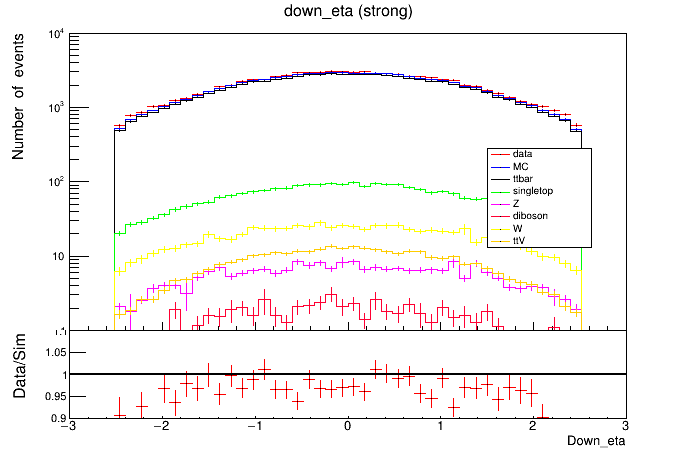

In [2]:
f_sel = root.TFile.Open("selection_mc16e_strict.root","read")
tree = f_sel.Get("selection")

can23 = root.TCanvas()
hist_data_down_eta = root.TH1D("hist_data_down_eta","down_eta (strong)",50,-3,3)
hist_MC_down_eta = root.TH1D("hist_MC_down_eta","down_eta",50,-3,3)
hist_deta_ttbar = root.TH1D("hist_deta_ttbar","down_eta",50,-3,3)
hist_deta_si = root.TH1D("hist_deta_si","down_eta",50,-3,3)
hist_deta_Z = root.TH1D("hist_deta_Z","down_eta",50,-3,3)
hist_deta_W = root.TH1D("hist_deta_W","down_eta",50,-3,3)
hist_deta_di = root.TH1D("hist_deta_di","down_eta",50,-3,3)
hist_deta_ttV = root.TH1D("hist_deta_ttV","down_eta",50,-3,3)

hist_MC_down_eta.SetLineColor(root.kBlue)
hist_data_down_eta.SetLineColor(root.kRed)
hist_deta_ttbar.SetLineColor(root.kBlack)
hist_deta_si.SetLineColor(root.kGreen)
hist_deta_Z.SetLineColor(root.kMagenta)
hist_deta_di.SetLineColor(root.kPink)
hist_deta_W.SetLineColor(root.kYellow)
hist_deta_ttV.SetLineColor(root.kOrange)

hist_MC_down_eta.SetStats(0)
hist_data_down_eta.SetStats(0)
hist_deta_ttbar.SetStats(0)
hist_deta_si.SetStats(0)
hist_deta_Z.SetStats(0)
hist_deta_di.SetStats(0)
hist_deta_W.SetStats(0)
hist_deta_ttV.SetStats(0)

pad1 = root.TPad("pad1","pad1" ,0,0.3,1,1)
pad1.SetLogy(True)
pad1.SetBottomMargin (0)
pad1.Draw()
pad1.cd()


tree.Draw("down_eta >> hist_data_down_eta","(settype==7)*event_weight","pe")
tree.Draw("down_eta >> hist_MC_down_eta","(settype!=7)*event_weight","h,same")
tree.Draw("down_eta >> hist_deta_ttbar","(settype==4)*event_weight","h,same")
tree.Draw("down_eta >> hist_deta_si","(settype==6)*event_weight","h,same")
tree.Draw("down_eta >> hist_deta_Z","(settype==3)*event_weight","h,same")
tree.Draw("down_eta >> hist_deta_di","(settype==5)*event_weight","h,same")
tree.Draw("down_eta >> hist_deta_W","(settype==2)*event_weight","h,same")
tree.Draw("down_eta >> hist_deta_ttV","(settype==1)*event_weight","h,same")

hist_data_down_eta.GetYaxis (). SetTitleSize (0.05)
hist_data_down_eta.GetYaxis().SetRangeUser (1 ,10000)
hist_data_down_eta.GetYaxis().SetTitle("Number  of  events")

legend = root.TLegend(.7,.25,.85,.55)
legend.AddEntry(hist_data_down_eta,"data");
legend.AddEntry(hist_MC_down_eta,"MC");
legend.AddEntry(hist_deta_ttbar,"ttbar");
legend.AddEntry(hist_deta_si,"singletop");
legend.AddEntry(hist_deta_Z,"Z");
legend.AddEntry(hist_deta_di,"diboson");
legend.AddEntry(hist_deta_W,"W");
legend.AddEntry(hist_deta_ttV,"ttV");


legend.Draw()

ratio = hist_MC_down_eta.Clone()
ratio.Divide(hist_data_down_eta)
ratio.SetLineColor(root.kRed)

can23.cd()
pad2 = root.TPad("pad2","pad2" ,0,0.05,1,0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad2.cd()
ratio.Draw("pe")
ratio.GetYaxis().SetRangeUser (0.9 ,1.1)
ratio.GetYaxis().SetNdivisions(207)
ratio.SetTitle("")
ratio.GetXaxis (). SetLabelSize (0.12)
ratio.GetXaxis (). SetTitleSize (0.12)
ratio.GetYaxis (). SetLabelSize (0.1)
ratio.GetYaxis (). SetTitleSize (0.15)
ratio.GetYaxis (). SetTitle("Data/Sim")
ratio.GetYaxis (). SetTitleOffset (0.3)
ratio.GetXaxis().SetTitle("Down_eta")

line = root.TLine (-3 ,1 ,3 ,1)
line.SetLineColor(root.kBlack)
line.SetLineWidth (2)
line.Draw("same")


can23.Draw()

can23.Print("downeta_pt_selection_strict_mc16e.png")

#settype = 1 (ttV)
#settype = 2 (W)
#settype = 3 (Z)
#settype = 4 (ttbar)
#settype = 5 (diboson)
#settype = 6 (single top)
#settype = 7 (data)

In [3]:
f_sel.Close()

Info in <TCanvas::Print>: png file hadtoppt_pt_selection_strict_mc16e.png has been created


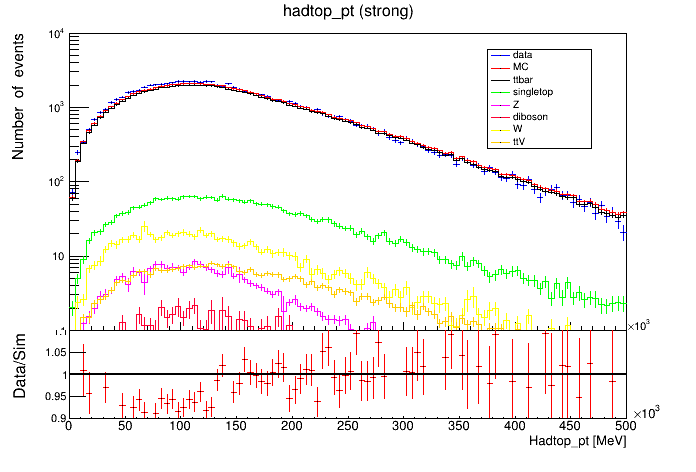

In [7]:
f_sel = root.TFile.Open("selection_mc16e_strict.root","read")
tree = f_sel.Get("selection")

can3 = root.TCanvas()
hist_data_hadtop_pt = root.TH1D("hist_data_hadtop_pt","hadtop_pt (strong)",100,0,500.e3)
hist_MC_hadtop_pt = root.TH1D("hist_MC_hadtop_pt","hadtop_pt",100,0,500.e3)
hist_htpt_ttbar = root.TH1D("hist_htpt_ttbar","hadtop_pt",100,0,500.e3)
hist_htpt_si = root.TH1D("hist_htpt_si","hadtop_pt",100,0,500.e3)
hist_htpt_Z = root.TH1D("hist_htpt_Z","hadtop_pt",100,0,500.e3)
hist_htpt_W = root.TH1D("hist_htpt_W","hadtop_pt",100,0,500.e3)
hist_htpt_di = root.TH1D("hist_htpt_di","hadtop_pt",100,0,500.e3)
hist_htpt_ttV = root.TH1D("hist_htpt_ttV","hadtop_pt",100,0,500.e3)

hist_data_hadtop_pt.SetLineColor(root.kBlue)
hist_MC_hadtop_pt.SetLineColor(root.kRed)
hist_htpt_ttbar.SetLineColor(root.kBlack)
hist_htpt_si.SetLineColor(root.kGreen)
hist_htpt_Z.SetLineColor(root.kMagenta)
hist_htpt_di.SetLineColor(root.kPink)
hist_htpt_W.SetLineColor(root.kYellow)
hist_htpt_ttV.SetLineColor(root.kOrange)

hist_data_hadtop_pt.SetStats(0)
hist_MC_hadtop_pt.SetStats(0)
hist_htpt_ttbar.SetStats(0)
hist_htpt_si.SetStats(0)
hist_htpt_Z.SetStats(0)
hist_htpt_di.SetStats(0)
hist_htpt_W.SetStats(0)
hist_htpt_ttV.SetStats(0)

pad1 = root.TPad("pad1","pad1" ,0,0.3,1,1)
pad1.SetLogy(True)
pad1.SetBottomMargin (0)
pad1.Draw()
pad1.cd()


tree.Draw("hadtop_pt >> hist_data_hadtop_pt","(settype==7)*event_weight","pe")
tree.Draw("hadtop_pt >> hist_MC_hadtop_pt","(settype!=7)*event_weight","h,same")
tree.Draw("hadtop_pt >> hist_htpt_ttbar","(settype==4)*event_weight","h,same")
tree.Draw("hadtop_pt >> hist_htpt_si","(settype==6)*event_weight","h,same")
tree.Draw("hadtop_pt >> hist_htpt_Z","(settype==3)*event_weight","h,same")
tree.Draw("hadtop_pt >> hist_htpt_di","(settype==5)*event_weight","h,same")
tree.Draw("hadtop_pt >> hist_htpt_W","(settype==2)*event_weight","h,same")
tree.Draw("hadtop_pt >> hist_htpt_ttV","(settype==1)*event_weight","h,same")

hist_data_hadtop_pt.GetYaxis (). SetTitleSize (0.05)
hist_data_hadtop_pt.GetYaxis().SetRangeUser (1 ,10000)
hist_data_hadtop_pt.GetYaxis().SetTitle("Number  of  events")

legend = root.TLegend(.7,.55,.85,.85)
legend.AddEntry(hist_data_hadtop_pt,"data");
legend.AddEntry(hist_MC_hadtop_pt,"MC");
legend.AddEntry(hist_htpt_ttbar,"ttbar");
legend.AddEntry(hist_htpt_si,"singletop");
legend.AddEntry(hist_htpt_Z,"Z");
legend.AddEntry(hist_htpt_di,"diboson");
legend.AddEntry(hist_htpt_W,"W");
legend.AddEntry(hist_htpt_ttV,"ttV");

legend.Draw()

ratio = hist_MC_hadtop_pt.Clone()
ratio.Divide(hist_data_hadtop_pt)
ratio.SetLineColor(root.kRed)

can3.cd()
pad2 = root.TPad("pad2","pad2" ,0,0.05,1,0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad2.cd()
ratio.Draw("pe")
ratio.GetYaxis().SetRangeUser (0.9 ,1.1)
ratio.GetYaxis().SetNdivisions(207)
ratio.SetTitle("")
ratio.GetXaxis (). SetLabelSize (0.12)
ratio.GetXaxis (). SetTitleSize (0.12)
ratio.GetYaxis (). SetLabelSize (0.1)
ratio.GetYaxis (). SetTitleSize (0.15)
ratio.GetYaxis (). SetTitle("Data/Sim")
ratio.GetYaxis (). SetTitleOffset (0.3)
ratio.GetXaxis().SetTitle("Hadtop_pt [MeV]")

line = root.TLine (1.e3 ,1 ,500.e3 ,1)
line.SetLineColor(root.kBlack)
line.SetLineWidth (2)
line.Draw("same")


can3.Draw()

can3.Print("hadtoppt_pt_selection_strict_mc16e.png")

#settype = 1 (ttV)
#settype = 2 (W)
#settype = 3 (Z)
#settype = 4 (ttbar)
#settype = 5 (diboson)
#settype = 6 (single top)
#settype = 7 (data)

In [8]:
f_sel.Close()

Info in <TCanvas::Print>: png file leptoppt_pt_selection_strict_mc16e.png has been created


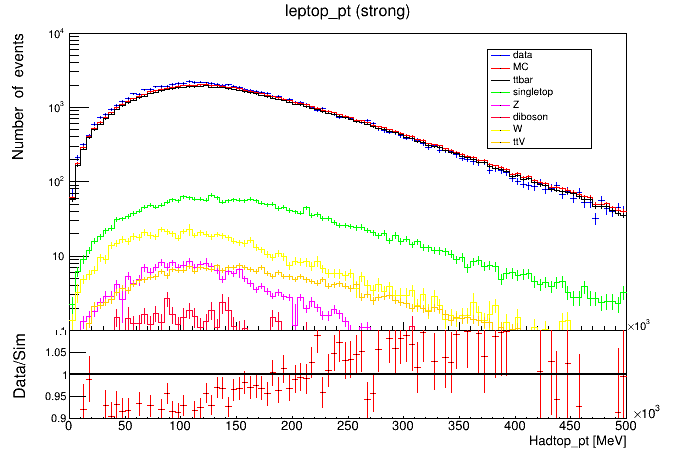

In [4]:
f_sel = root.TFile.Open("selection_mc16e_strict.root","read")
tree = f_sel.Get("selection")

can4 = root.TCanvas()
hist_data_leptop_pt = root.TH1D("hist_data_leptop_pt","leptop_pt (strong)",100,0,500.e3)
hist_MC_leptop_pt = root.TH1D("hist_MC_leptop_pt","leptop_pt",100,0,500.e3)
hist_ltpt_ttbar = root.TH1D("hist_ltpt_ttbar","leptop_pt",100,0,500.e3)
hist_ltpt_si = root.TH1D("hist_ltpt_si","leptop_pt",100,0,500.e3)
hist_ltpt_Z = root.TH1D("hist_ltpt_Z","leptop_pt",100,0,500.e3)
hist_ltpt_W = root.TH1D("hist_ltpt_W","leptop_pt",100,0,500.e3)
hist_ltpt_di = root.TH1D("hist_ltpt_di","leptop_pt",100,0,500.e3)
hist_ltpt_ttV = root.TH1D("hist_ltpt_ttV","leptop_pt",100,0,500.e3)

hist_data_leptop_pt.SetLineColor(root.kBlue)
hist_MC_leptop_pt.SetLineColor(root.kRed)
hist_ltpt_ttbar.SetLineColor(root.kBlack)
hist_ltpt_si.SetLineColor(root.kGreen)
hist_ltpt_Z.SetLineColor(root.kMagenta)
hist_ltpt_di.SetLineColor(root.kPink)
hist_ltpt_W.SetLineColor(root.kYellow)
hist_ltpt_ttV.SetLineColor(root.kOrange)

hist_data_leptop_pt.SetStats(0)
hist_MC_leptop_pt.SetStats(0)
hist_ltpt_ttbar.SetStats(0)
hist_ltpt_si.SetStats(0)
hist_ltpt_Z.SetStats(0)
hist_ltpt_di.SetStats(0)
hist_ltpt_W.SetStats(0)
hist_ltpt_ttV.SetStats(0)

pad1 = root.TPad("pad1","pad1" ,0,0.3,1,1)
pad1.SetLogy(True)
pad1.SetBottomMargin (0)
pad1.Draw()
pad1.cd()


tree.Draw("leptop_pt >> hist_data_leptop_pt","(settype==7)*event_weight","pe")
tree.Draw("leptop_pt >> hist_MC_leptop_pt","(settype!=7)*event_weight","h,same")
tree.Draw("leptop_pt >> hist_ltpt_ttbar","(settype==4)*event_weight","h,same")
tree.Draw("leptop_pt >> hist_ltpt_si","(settype==6)*event_weight","h,same")
tree.Draw("leptop_pt >> hist_ltpt_Z","(settype==3)*event_weight","h,same")
tree.Draw("leptop_pt >> hist_ltpt_di","(settype==5)*event_weight","h,same")
tree.Draw("leptop_pt >> hist_ltpt_W","(settype==2)*event_weight","h,same")
tree.Draw("leptop_pt >> hist_ltpt_ttV","(settype==1)*event_weight","h,same")

hist_data_leptop_pt.GetYaxis (). SetTitleSize (0.05)
hist_data_leptop_pt.GetYaxis().SetRangeUser (1 ,10000)
hist_data_leptop_pt.GetYaxis().SetTitle("Number  of  events")

legend = root.TLegend(.7,.55,.85,.85)
legend.AddEntry(hist_data_leptop_pt,"data");
legend.AddEntry(hist_MC_leptop_pt,"MC");
legend.AddEntry(hist_ltpt_ttbar,"ttbar");
legend.AddEntry(hist_ltpt_si,"singletop");
legend.AddEntry(hist_ltpt_Z,"Z");
legend.AddEntry(hist_ltpt_di,"diboson");
legend.AddEntry(hist_ltpt_W,"W");
legend.AddEntry(hist_ltpt_ttV,"ttV");

legend.Draw()

ratio = hist_MC_leptop_pt.Clone()
ratio.Divide(hist_data_leptop_pt)
ratio.SetLineColor(root.kRed)

can4.cd()
pad2 = root.TPad("pad2","pad2" ,0,0.05,1,0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad2.cd()
ratio.Draw("pe")
ratio.GetYaxis().SetRangeUser (0.9 ,1.1)
ratio.GetYaxis().SetNdivisions(207)
ratio.SetTitle("")
ratio.GetXaxis (). SetLabelSize (0.12)
ratio.GetXaxis (). SetTitleSize (0.12)
ratio.GetYaxis (). SetLabelSize (0.1)
ratio.GetYaxis (). SetTitleSize (0.15)
ratio.GetYaxis (). SetTitle("Data/Sim")
ratio.GetYaxis (). SetTitleOffset (0.3)
ratio.GetXaxis().SetTitle("Hadtop_pt [MeV]")

line = root.TLine (1.e3 ,1 ,500.e3 ,1)
line.SetLineColor(root.kBlack)
line.SetLineWidth (2)
line.Draw("same")


can4.Draw()

can4.Print("leptoppt_pt_selection_strict_mc16e.png")

#settype = 1 (ttV)
#settype = 2 (W)
#settype = 3 (Z)
#settype = 4 (ttbar)
#settype = 5 (diboson)
#settype = 6 (single top)
#settype = 7 (data)

In [6]:
f_sel.Close()

Info in <TCanvas::Print>: png file ttpt_pt_selection_strict_mc16e.png has been created


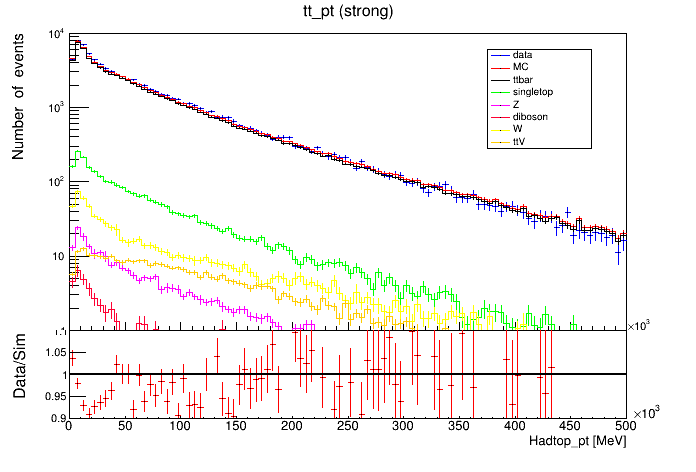

In [7]:
f_sel = root.TFile.Open("selection_mc16e_strict.root","read")
tree = f_sel.Get("selection")

can5 = root.TCanvas()
hist_data_tt_pt = root.TH1D("hist_data_tt_pt","tt_pt (strong)",100,0,500.e3)
hist_MC_tt_pt = root.TH1D("hist_MC_tt_pt","tt_pt",100,0,500.e3)
hist_ttpt_ttbar = root.TH1D("hist_ttpt_ttbar","tt_pt",100,0,500.e3)
hist_ttpt_si = root.TH1D("hist_ttpt_si","tt_pt",100,0,500.e3)
hist_ttpt_Z = root.TH1D("hist_ttpt_Z","tt_pt",100,0,500.e3)
hist_ttpt_W = root.TH1D("hist_ttpt_W","tt_pt",100,0,500.e3)
hist_ttpt_di = root.TH1D("hist_ttpt_di","tt_pt",100,0,500.e3)
hist_ttpt_ttV = root.TH1D("hist_ttpt_ttV","tt_pt",100,0,500.e3)

hist_data_tt_pt.SetLineColor(root.kBlue)
hist_MC_tt_pt.SetLineColor(root.kRed)
hist_ttpt_ttbar.SetLineColor(root.kBlack)
hist_ttpt_si.SetLineColor(root.kGreen)
hist_ttpt_Z.SetLineColor(root.kMagenta)
hist_ttpt_di.SetLineColor(root.kPink)
hist_ttpt_W.SetLineColor(root.kYellow)
hist_ttpt_ttV.SetLineColor(root.kOrange)

hist_data_tt_pt.SetStats(0)
hist_MC_tt_pt.SetStats(0)
hist_ttpt_ttbar.SetStats(0)
hist_ttpt_si.SetStats(0)
hist_ttpt_Z.SetStats(0)
hist_ttpt_di.SetStats(0)
hist_ttpt_W.SetStats(0)
hist_ttpt_ttV.SetStats(0)

pad1 = root.TPad("pad1","pad1" ,0,0.3,1,1)
pad1.SetLogy(True)
pad1.SetBottomMargin (0)
pad1.Draw()
pad1.cd()


tree.Draw("tt_pt >> hist_data_tt_pt","(settype==7)*event_weight","pe")
tree.Draw("tt_pt >> hist_MC_tt_pt","(settype!=7)*event_weight","h,same")
tree.Draw("tt_pt >> hist_ttpt_ttbar","(settype==4)*event_weight","h,same")
tree.Draw("tt_pt >> hist_ttpt_si","(settype==6)*event_weight","h,same")
tree.Draw("tt_pt >> hist_ttpt_Z","(settype==3)*event_weight","h,same")
tree.Draw("tt_pt >> hist_ttpt_di","(settype==5)*event_weight","h,same")
tree.Draw("tt_pt >> hist_ttpt_W","(settype==2)*event_weight","h,same")
tree.Draw("tt_pt >> hist_ttpt_ttV","(settype==1)*event_weight","h,same")

hist_data_tt_pt.GetYaxis (). SetTitleSize (0.05)
hist_data_tt_pt.GetYaxis().SetRangeUser (1 ,10000)
hist_data_tt_pt.GetYaxis().SetTitle("Number  of  events")

legend = root.TLegend(.7,.55,.85,.85)
legend.AddEntry(hist_data_tt_pt,"data");
legend.AddEntry(hist_MC_tt_pt,"MC");
legend.AddEntry(hist_ttpt_ttbar,"ttbar");
legend.AddEntry(hist_ttpt_si,"singletop");
legend.AddEntry(hist_ttpt_Z,"Z");
legend.AddEntry(hist_ttpt_di,"diboson");
legend.AddEntry(hist_ttpt_W,"W");
legend.AddEntry(hist_ttpt_ttV,"ttV");


legend.Draw()

ratio = hist_MC_tt_pt.Clone()
ratio.Divide(hist_data_tt_pt)
ratio.SetLineColor(root.kRed)

can5.cd()
pad2 = root.TPad("pad2","pad2" ,0,0.05,1,0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad2.cd()
ratio.Draw("pe")
ratio.GetYaxis().SetRangeUser (0.9 ,1.1)
ratio.GetYaxis().SetNdivisions(207)
ratio.SetTitle("")
ratio.GetXaxis (). SetLabelSize (0.12)
ratio.GetXaxis (). SetTitleSize (0.12)
ratio.GetYaxis (). SetLabelSize (0.1)
ratio.GetYaxis (). SetTitleSize (0.15)
ratio.GetYaxis (). SetTitle("Data/Sim")
ratio.GetYaxis (). SetTitleOffset (0.3)
ratio.GetXaxis().SetTitle("Hadtop_pt [MeV]")

line = root.TLine (1.e3 ,1 ,500.e3 ,1)
line.SetLineColor(root.kBlack)
line.SetLineWidth (2)
line.Draw("same")


can5.Draw()

can5.Print("ttpt_pt_selection_strict_mc16e.png")

#settype = 1 (ttV)
#settype = 2 (W)
#settype = 3 (Z)
#settype = 4 (ttbar)
#settype = 5 (diboson)
#settype = 6 (single top)
#settype = 7 (data)

In [8]:
f_sel.Close()

In [2]:
f_sel = root.TFile.Open("selection_mc16e_strict.root","read")
tree = f_sel.Get("selection")

can6 = root.TCanvas()
hist_data_met = root.TH1D("hist_data_met","met (strong)",100,0,500.e3)
hist_MC_met = root.TH1D("hist_MC_met","met",100,0,500.e3)
hist_met_ttbar = root.TH1D("hist_met_ttbar","met",100,0,500.e3)
hist_met_si = root.TH1D("hist_met_si","met",100,0,500.e3)
hist_met_Z = root.TH1D("hist_met_Z","met",100,0,500.e3)
hist_met_W = root.TH1D("hist_met_W","met",100,0,500.e3)
hist_met_di = root.TH1D("hist_met_di","met",100,0,500.e3)
hist_met_ttV = root.TH1D("hist_met_ttV","met",100,0,500.e3)

hist_data_met.SetLineColor(root.kBlue)
hist_MC_met.SetLineColor(root.kRed)
hist_met_ttbar.SetLineColor(root.kBlack)
hist_met_si.SetLineColor(root.kGreen)
hist_met_Z.SetLineColor(root.kMagenta)
hist_met_di.SetLineColor(root.kPink)
hist_met_W.SetLineColor(root.kYellow)
hist_met_ttV.SetLineColor(root.kOrange)

hist_data_met.SetStats(0)
hist_MC_met.SetStats(0)
hist_met_ttbar.SetStats(0)
hist_met_si.SetStats(0)
hist_met_Z.SetStats(0)
hist_met_di.SetStats(0)
hist_met_W.SetStats(0)
hist_met_ttV.SetStats(0)

pad1 = root.TPad("pad1","pad1" ,0,0.3,1,1)
pad1.SetLogy(True)
pad1.SetBottomMargin (0)
pad1.Draw()
pad1.cd()


tree.Draw("m_met >> hist_data_met","(settype==7)*event_weight","pe")
tree.Draw("m_met >> hist_MC_met","(settype!=7)*event_weight","h,same")
tree.Draw("m_met >> hist_met_ttbar","(settype==4)*event_weight","h,same")
tree.Draw("m_met >> hist_met_si","(settype==6)*event_weight","h,same")
tree.Draw("m_met >> hist_met_Z","(settype==3)*event_weight","h,same")
tree.Draw("m_met >> hist_met_di","(settype==5)*event_weight","h,same")
tree.Draw("m_met >> hist_met_W","(settype==2)*event_weight","h,same")
tree.Draw("m_met >> hist_met_ttV","(settype==1)*event_weight","h,same")

hist_data_tt_pt.GetYaxis (). SetTitleSize (0.05)
hist_data_tt_pt.GetYaxis().SetRangeUser (1 ,10000)
hist_data_tt_pt.GetYaxis().SetTitle("Number  of  events")

legend = root.TLegend(.7,.55,.85,.85)
legend.AddEntry(hist_data_met,"data");
legend.AddEntry(hist_MC_met,"MC");
legend.AddEntry(hist_met_ttbar,"ttbar");
legend.AddEntry(hist_met_si,"singletop");
legend.AddEntry(hist_met_Z,"Z");
legend.AddEntry(hist_met_di,"diboson");
legend.AddEntry(hist_met_W,"W");
legend.AddEntry(hist_met_ttV,"ttV");


legend.Draw()

ratio = hist_MC_met.Clone()
ratio.Divide(hist_data_met)
ratio.SetLineColor(root.kRed)

can6.cd()
pad2 = root.TPad("pad2","pad2" ,0,0.05,1,0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad2.cd()
ratio.Draw("pe")
ratio.GetYaxis().SetRangeUser (0.9 ,1.1)
ratio.GetYaxis().SetNdivisions(207)
ratio.SetTitle("")
ratio.GetXaxis (). SetLabelSize (0.12)
ratio.GetXaxis (). SetTitleSize (0.12)
ratio.GetYaxis (). SetLabelSize (0.1)
ratio.GetYaxis (). SetTitleSize (0.15)
ratio.GetYaxis (). SetTitle("Data/Sim")
ratio.GetYaxis (). SetTitleOffset (0.3)
ratio.GetXaxis().SetTitle("Missing ET [MeV]")

line = root.TLine (1.e3 ,1 ,500.e3 ,1)
line.SetLineColor(root.kBlack)
line.SetLineWidth (2)
line.Draw("same")


can6.Draw()

can6.Print("met_pt_selection_strict_mc16e.png")

#settype = 1 (ttV)
#settype = 2 (W)
#settype = 3 (Z)
#settype = 4 (ttbar)
#settype = 5 (diboson)
#settype = 6 (single top)
#settype = 7 (data)

NameError: name 'hist_data_tt_pt' is not defined

658.3505015036492
2072.2972512504607
671.7841053796719
5350.461215585841
145.09104223835297
175888.0
154363.91123171124
163261.89534766917


Info in <TCanvas::Print>: png file downpt_pt_selection_2_mc16e.png has been created


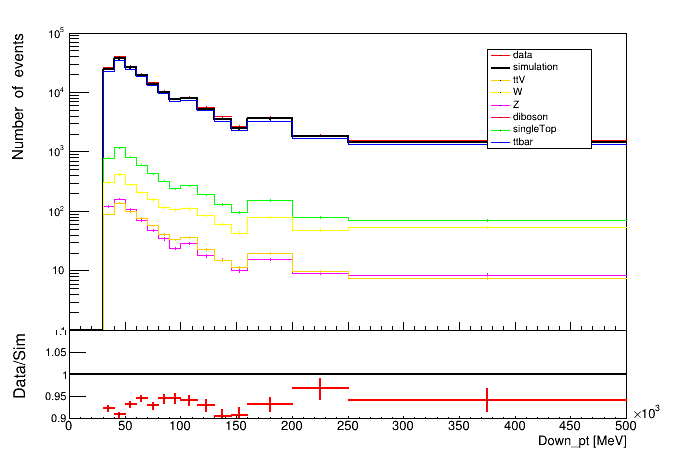

In [25]:
h_ttc = h_tt.Clone()
h_ttVc = h_ttV.Clone()
h_Wc = h_W.Clone()
h_Zc = h_Z.Clone()
h_sic = h_si.Clone()
h_dic = h_di.Clone()

h_sim = h_ttc + h_ttVc + h_Wc + h_Zc + h_sic + h_dic


c1 = root.TCanvas()
c1.Clear()
c1.SetLogy(True)



h_ttV.SetStats(0)
h_W.SetStats(0)
h_Z.SetStats(0)
h_si.SetStats(0)
h_di.SetStats(0)
h_data.SetStats(0)
h_tt.SetStats(0)
h_sim.SetStats(0)


h_tt.SetLineColor(root.kBlue)
h_data.SetLineColor(root.kRed)
h_si.SetLineColor(root.kGreen)
h_Z.SetLineColor(root.kMagenta)
h_di.SetLineColor(root.kPink)
h_W.SetLineColor(root.kYellow)
h_ttV.SetLineColor(root.kOrange)

h_sim.SetLineColor(root.kBlack)
h_sim.SetLineWidth(2)


pad1 = root.TPad("pad1","pad1" ,0,0.3,1,1)
pad1.SetLogy(True)
pad1.SetBottomMargin (0)
pad1.Draw()
pad1.cd()

h_data.Draw("pe")
h_sim.Draw("h,same")
h_tt.Draw("h,same")
h_si.Draw("h,same")
h_Z.Draw("h,same")
h_W.Draw("h,same")
h_ttV.Draw("h,same")

h_data.SetTitle("")
h_data.GetYaxis (). SetTitleSize (0.05)
h_data.GetYaxis().SetRangeUser (1 ,100000)
h_data.GetXaxis().SetLabelSize (0)
h_data.GetXaxis().SetTitleSize (0)
h_data.GetYaxis().SetTitle("Number  of  events")

print(h_ttV.Integral())
print(h_W.Integral())
print(h_Z.Integral())
print(h_si.Integral())
print(h_di.Integral())
print(h_data.Integral())
print(h_tt.Integral())
print(h_sim.Integral())


legend = root.TLegend(.7,.55,.85,.85)
legend.AddEntry(h_data,"data");
legend.AddEntry(h_sim,"simulation");
legend.AddEntry(h_ttV,"ttV");
legend.AddEntry(h_W,"W");
legend.AddEntry(h_Z,"Z");
legend.AddEntry(h_di,"diboson");
legend.AddEntry(h_si,"singleTop");
legend.AddEntry(h_tt,"ttbar");

legend.Draw()


ratio = h_sim.Clone()
ratio.Divide(h_data)
ratio.SetLineColor(root.kRed)

c1.cd()
pad2 = root.TPad("pad2","pad2" ,0,0.05,1,0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad2.cd()
ratio.Draw("pe")
ratio.GetYaxis().SetRangeUser (0.9 ,1.1)
ratio.GetYaxis().SetNdivisions(207)
ratio.SetTitle("")
ratio.GetXaxis (). SetLabelSize (0.12)
ratio.GetXaxis (). SetTitleSize (0.12)
ratio.GetYaxis (). SetLabelSize (0.1)
ratio.GetYaxis (). SetTitleSize (0.15)
ratio.GetYaxis (). SetTitle("Data/Sim")
ratio.GetYaxis (). SetTitleOffset (0.3)
ratio.GetXaxis().SetTitle("Down_pt [MeV]")

line = root.TLine (1.e3 ,1 ,500.e3 ,1)
line.SetLineColor(root.kBlack)
line.SetLineWidth (2)
line.Draw("same")

#rp = root.TRatioPlot(histoadata, histoprune4)
#histoprune4.SetTitle("")

#rp.Draw()

c1.Draw()
c1.Print("downpt_pt_selection_2_mc16e.png")

In [ ]:
f_ttV.Close()
f_W.Close()
f_Z.Close()
f_tt.Close()
f_di.Close()
f_si.Close()
f_data.Close()


In [ ]:
print(h_ttV.Integral())
print(h_W.Integral())
print(h_Z.Integral())
print(h_si.Integral())
print(h_di.Integral())
print(h_data.Integral())
print(h_tt.Integral())
print(h_sim.Integral())

In [ ]:
d6 = root.TFile.Open("output_mc16d/ttV.root","read")
d2 = root.TFile.Open("output_mc16d/Wjets.root","read")
d3 = root.TFile.Open("output_mc16d/Zjets.root","read")
ddata = root.TFile.Open("output_mc16d/data.root","read")
d4 = root.TFile.Open("output_mc16d/diboson.root","read")
d5 = root.TFile.Open("output_mc16d/singleTop.root","read")
d1 = root.TFile.Open("output_mc16d/ttbar.root","read")

In [ ]:
tree = ddata.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

histoddata = root.TH1D("data","down_pt",10,0, 500000)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (m_cjets == []):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
 
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    
    #m_down = getDownTypeJet_massWindow_m(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 7*GeV)
    
    #m_down = getDownTypeJet_massWindow_mixed(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV, 6*GeV)
    
    #m_down = getDownTypeJet_massWindow_eta(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 1.5)
    
    #m_down = getDownTypeJet_massWindow_Limit(m_had_b, m_cjet, m_lep_b, jets, m_mTop, m_limit)
    
    #m_down = getDownTypeJet_massWindowdRHybrid(m_had_b, m_cjet, m_lep_b, jets, m_mTop, verbose)
    
    #m_down = getDownTypeJet_deltaR(m_had_b, m_cjet, m_lep_b, jets)

    if (m_down == []):
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    

    m_ttbar = m_hadtop + m_leptop
    
    down_pt = event.jet_pt[event.down_index]
    down_m = event.jet_m[event.down_index]
    down_eta = event.jet_eta[event.down_index]
    down_phi = event.jet_phi[event.down_index]
    
    histoddata.Fill(down_pt,event.event_weight)
    

In [ ]:
tree = d1.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

histod1 = root.TH1D("ttbar","down_pt",10,0, 500000)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (m_cjets == []):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
 
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    
    #m_down = getDownTypeJet_massWindow_m(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 7*GeV)
    
    #m_down = getDownTypeJet_massWindow_mixed(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV, 6*GeV)
    
    #m_down = getDownTypeJet_massWindow_eta(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 1.5)
    
    #m_down = getDownTypeJet_massWindow_Limit(m_had_b, m_cjet, m_lep_b, jets, m_mTop, m_limit)
    
    #m_down = getDownTypeJet_massWindowdRHybrid(m_had_b, m_cjet, m_lep_b, jets, m_mTop, verbose)
    
    #m_down = getDownTypeJet_deltaR(m_had_b, m_cjet, m_lep_b, jets)

    if (m_down == []):
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    

    m_ttbar = m_hadtop + m_leptop
    
    down_pt = event.jet_pt[event.down_index]
    down_m = event.jet_m[event.down_index]
    down_eta = event.jet_eta[event.down_index]
    down_phi = event.jet_phi[event.down_index]
    
    histod1.Fill(down_pt,event.event_weight)

In [46]:
tree = d2.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

histod2 = root.TH1D("Wjets","down_pt",10,0, 500000)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (m_cjets == []):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
 
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    
    #m_down = getDownTypeJet_massWindow_m(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 7*GeV)
    
    #m_down = getDownTypeJet_massWindow_mixed(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV, 6*GeV)
    
    #m_down = getDownTypeJet_massWindow_eta(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 1.5)
    
    #m_down = getDownTypeJet_massWindow_Limit(m_had_b, m_cjet, m_lep_b, jets, m_mTop, m_limit)
    
    #m_down = getDownTypeJet_massWindowdRHybrid(m_had_b, m_cjet, m_lep_b, jets, m_mTop, verbose)
    
    #m_down = getDownTypeJet_deltaR(m_had_b, m_cjet, m_lep_b, jets)

    if (m_down == []):
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    

    m_ttbar = m_hadtop + m_leptop
    
    down_pt = event.jet_pt[event.down_index]
    down_m = event.jet_m[event.down_index]
    down_eta = event.jet_eta[event.down_index]
    down_phi = event.jet_phi[event.down_index]
    
    histod2.Fill(down_pt,event.event_weight)

Warning in <TFile::Append>: Replacing existing TH1: Wjets (Potential memory leak).


In [47]:
tree = d3.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

histod3 = root.TH1D("Zjets","down_pt",10,0, 500000)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (m_cjets == []):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
 
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    
    #m_down = getDownTypeJet_massWindow_m(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 7*GeV)
    
    #m_down = getDownTypeJet_massWindow_mixed(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV, 6*GeV)
    
    #m_down = getDownTypeJet_massWindow_eta(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 1.5)
    
    #m_down = getDownTypeJet_massWindow_Limit(m_had_b, m_cjet, m_lep_b, jets, m_mTop, m_limit)
    
    #m_down = getDownTypeJet_massWindowdRHybrid(m_had_b, m_cjet, m_lep_b, jets, m_mTop, verbose)
    
    #m_down = getDownTypeJet_deltaR(m_had_b, m_cjet, m_lep_b, jets)

    if (m_down == []):
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    

    m_ttbar = m_hadtop + m_leptop
    
    down_pt = event.jet_pt[event.down_index]
    down_m = event.jet_m[event.down_index]
    down_eta = event.jet_eta[event.down_index]
    down_phi = event.jet_phi[event.down_index]
    
    histod3.Fill(down_pt,event.event_weight)

Warning in <TFile::Append>: Replacing existing TH1: Zjets (Potential memory leak).


In [48]:
tree = d4.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

histod4 = root.TH1D("diboson","down_pt",10,0, 500000)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (m_cjets == []):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
 
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    
    #m_down = getDownTypeJet_massWindow_m(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 7*GeV)
    
    #m_down = getDownTypeJet_massWindow_mixed(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV, 6*GeV)
    
    #m_down = getDownTypeJet_massWindow_eta(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 1.5)
    
    #m_down = getDownTypeJet_massWindow_Limit(m_had_b, m_cjet, m_lep_b, jets, m_mTop, m_limit)
    
    #m_down = getDownTypeJet_massWindowdRHybrid(m_had_b, m_cjet, m_lep_b, jets, m_mTop, verbose)
    
    #m_down = getDownTypeJet_deltaR(m_had_b, m_cjet, m_lep_b, jets)

    if (m_down == []):
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    

    m_ttbar = m_hadtop + m_leptop
    
    down_pt = event.jet_pt[event.down_index]
    down_m = event.jet_m[event.down_index]
    down_eta = event.jet_eta[event.down_index]
    down_phi = event.jet_phi[event.down_index]
    
    histod4.Fill(down_pt,event.event_weight)

Warning in <TFile::Append>: Replacing existing TH1: diboson (Potential memory leak).


In [49]:
tree = d5.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

histod5 = root.TH1D("singleTop","down_pt",10,0, 500000)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (m_cjets == []):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
 
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    
    #m_down = getDownTypeJet_massWindow_m(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 7*GeV)
    
    #m_down = getDownTypeJet_massWindow_mixed(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV, 6*GeV)
    
    #m_down = getDownTypeJet_massWindow_eta(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 1.5)
    
    #m_down = getDownTypeJet_massWindow_Limit(m_had_b, m_cjet, m_lep_b, jets, m_mTop, m_limit)
    
    #m_down = getDownTypeJet_massWindowdRHybrid(m_had_b, m_cjet, m_lep_b, jets, m_mTop, verbose)
    
    #m_down = getDownTypeJet_deltaR(m_had_b, m_cjet, m_lep_b, jets)

    if (m_down == []):
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    

    m_ttbar = m_hadtop + m_leptop
    
    down_pt = event.jet_pt[event.down_index]
    down_m = event.jet_m[event.down_index]
    down_eta = event.jet_eta[event.down_index]
    down_phi = event.jet_phi[event.down_index]
    
    histod5.Fill(down_pt,event.event_weight)

Warning in <TFile::Append>: Replacing existing TH1: singleTop (Potential memory leak).


In [50]:
tree = d6.Get("nominal")

index = 0
index2 = 0
index3 = 0
listing = []
masses = np.array(listing)

histod6 = root.TH1D("ttV","down_pt",10,0, 500000)

for event in tree: # loop around all the events in the file

    njets = event.jet_pt.size() # check how many jets are in the event
    
    index += 1
    
    verbose = 0
    
    m_bjet_PCB = 4   
    m_cjet_PCB = 1

    jets = []   
    pcbs = []    
    m_bjets = []
    m_cjets = []
    jet_truth_matches = []
    
    GeV = 1000
    
    m_limit = 100*GeV
    
    m_mW = 80.4*GeV   
    m_mTop = 172.5*GeV
    
    met_met = event.met_met
    met_phi = event.met_phi
    m_met_x = met_met*np.cos(met_phi)
    m_met_y = met_met*np.sin(met_phi)

    for ijet in range(0, njets): # loop around the jets in the event

        temp_jet = root.TLorentzVector()

        temp_jet.SetPtEtaPhiM(event.jet_pt[ijet], event.jet_eta[ijet], event.jet_phi[ijet], event.jet_m[ijet]) # read the jet info into a TLorentzVector

        jets.append(temp_jet)
        
        t_pcb = event.jet_pcb[ijet]
        
        pcbs.append(t_pcb)
        
        t_truth = event.jet_truth_match[ijet]
        
        jet_truth_matches.append(t_truth)
        
    m_lepton = root.TLorentzVector()           
    m_lepton.SetPtEtaPhiM(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0], event.lep_m[0])
    
    m_bjets = getBJets(jets, m_bjet_PCB, pcbs, m_bjets)
    
    m_lep_b = getLeptonicBJet(m_lepton, m_bjets)
    
    m_neutrino = getNeutrino(m_mW, m_lepton, m_met_x, m_met_y)
    
    m_leptop = m_lepton + m_lep_b + m_neutrino
    
    m_cjets = getCJets(m_cjet_PCB, m_bjet_PCB, jets, pcbs, m_cjets)
    
    if (m_cjets == []):
        continue
    
    m_cjet = m_cjets[0]
    
    index2 += 1
    
    m_had_b = getHadronicBJet(m_bjets)
    
 
    #m_down = getDownTypeJet_massWindow(m_had_b, m_cjet, m_lep_b, jets, m_mTop)
    
    m_down = getDownTypeJet_massWindow_pt(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV)
    
    #m_down = getDownTypeJet_massWindow_m(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 7*GeV)
    
    #m_down = getDownTypeJet_massWindow_mixed(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 35*GeV, 6*GeV)
    
    #m_down = getDownTypeJet_massWindow_eta(m_had_b, m_cjet, m_lep_b, jets, m_mTop, 1.5)
    
    #m_down = getDownTypeJet_massWindow_Limit(m_had_b, m_cjet, m_lep_b, jets, m_mTop, m_limit)
    
    #m_down = getDownTypeJet_massWindowdRHybrid(m_had_b, m_cjet, m_lep_b, jets, m_mTop, verbose)
    
    #m_down = getDownTypeJet_deltaR(m_had_b, m_cjet, m_lep_b, jets)

    if (m_down == []):
        continue

    m_hadtop = m_down + m_had_b + m_cjet
    

    m_ttbar = m_hadtop + m_leptop
    
    down_pt = event.jet_pt[event.down_index]
    down_m = event.jet_m[event.down_index]
    down_eta = event.jet_eta[event.down_index]
    down_phi = event.jet_phi[event.down_index]
    
    histod6.Fill(down_pt,event.event_weight)

Warning in <TFile::Append>: Replacing existing TH1: ttV (Potential memory leak).


Warning in <TFile::Append>: Replacing existing TH1: ttdsim (Potential memory leak).


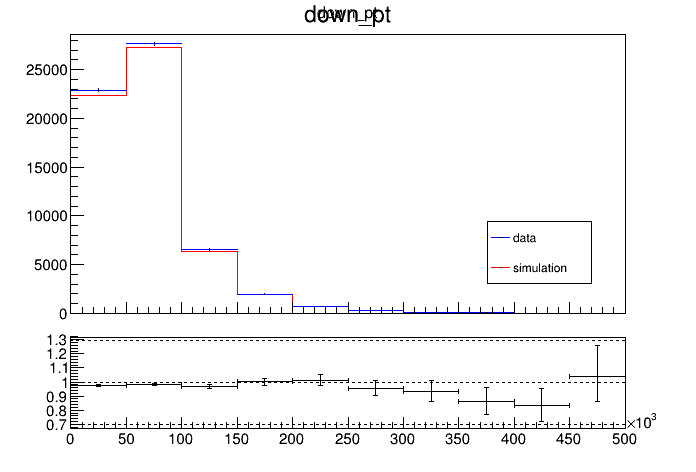

In [55]:
histodsim = root.TH1D("ttdsim","down_pt",10,0, 500000)

histodsim.Add(histodsim,histod1,1.0)
histodsim.Add(histodsim,histod2,1.0)
histodsim.Add(histodsim,histod3,1.0)
histodsim.Add(histodsim,histod4,1.0)
histodsim.Add(histodsim,histod5,1.0)
histodsim.Add(histodsim,histod6,1.0)

can2 = root.TCanvas()

histodsim.SetStats(0)
histoddata.SetStats(0)



histoddata.SetLineColor(root.kBlue)
histodsim.SetLineColor(root.kRed)


histoddata.Draw("h")
histodsim.Draw("h,same")

rp = root.TRatioPlot(histodsim, histoddata)


legend = root.TLegend(.7,.4,.85,.53)
legend.AddEntry(histoddata,"data");
legend.AddEntry(histodsim,"simulation");

rp.Draw()
legend.Draw()
can2.Draw()


XSEC2 Set, BPCB = 4

CPCB = 1
hybrid: 66.32055538648977%
mass_window: 66.32819504839269%
deltaR: 63.30211774505674%
No. of events: 6424
Events with cjet identified: 6424
    
CPCB = 2
hybrid: 70.28456795791195%
mass_window: 71.37027331151855%
DeltaR: 66.15431584513203%
No. of events: 6424
Events with cjet identified: 2703

CPCB = 3
hybrid: 67.51952112353689%
mass_window: 68.47616055708853%
DeltaR: 67.36012636234292%
No. of events: 6424
Events with cjet identified: 1085 


Mass limit = 100 GeV
CPCB = 1
mass_window: 68.13759289882306%
No. of events included: 5314
Total no. of events: 6424
% included: 82.72104607721046%

Mass limit = 80 GeV
CPCB = 1
mass_window: 68.13884111408478%
No. of events included: 5041
Total no. of events: 6424
% included: 78.47135740971358%

Mass limit = 60 GeV
CPCB = 1
mass_window: 68.13613125375183%
No. of events included: 4659
Total no. of events: 6424
% included: 72.52490660024907%

Mass limit = 40 GeV
CPCB = 1
mass_window: 68.13759289882306%
No. of events included: 3915
Total no. of events: 6424
% included: 60.94333748443338%

Mass limit = 20 GeV
CPCB = 1
mass_window: 68.98413347332114%
No. of events included: 2653
Total no. of events: 6424
% included: 41.29825653798257%



eta < 2.0
CPCB = 1
acc: 66.57169071628897%
events included: 5676 (88.35616438356165%)

eta < 1.0
CPCB = 1
acc: 65.15442218024263%
events included: 3311 (51.54109589041096%)

eta < 1.5
CPCB = 1
acc: 66.44551847169514%
events included: 4681 (72.86737235367372%)


Pt > 45 GeV
CPCB = 1
acc: 77.76989397624551%
events: 776 (12.079701120797012%)

Pt > 40 GeV
CPCB = 1
acc: 76.96073485849813%
events included: 1292 (20.1120797011208%)

Pt > 36 GeV
CPCB = 1
acc: 75.39454331925187%
events: 1996 (31.07098381070984%)

Pt > 35 GeV
CPCB = 1
acc: 75.02344341849667%
events: 2208 (34.37110834371108%)

Pt > 30 GeV
CPCB = 1
acc: 70.96038474852946%
events: 3695 (57.5186799501868%)


m > 5 GeV
CPCB = 1
acc: 67.37451358839421%
events included: 3809 (59.29327521793275%)

m > 6 GeV
CPCB = 1
acc: 70.08243903552057%
events included: 2185 (34.01307596513076%)

m > 7 GeV
CPCB = 1
acc: 73.16790675405412%
events included: 1037 (16.142590286425904%)


m > 6 GeV, Pt > 36 GeV
CPCB = 1
acc: 75.31762150431832%
events included: 1269 (19.754047322540476%)

m > 6 GeV, Pt > 35 GeV
CPCB = 1
acc: 74.70238572006315%
events included: 1346 (20.952677459526775%)





 
Full Stats Set, BPCB = 4 

CPCB = 3
mass_window: 68.00287521162186%
No. of events considered: 4428588
Events with cjet identified: 752442
    
CPCB = 2
mass_window: 68.75378642341774%
No. of events considered: 4428588
Events with cjet identified: 1909762
    
CPCB = 1
mass_window: 65.38909861795725%
No. of events considered: 4428588
Events with cjet identified: 4428588



Pt > 40 GeV
CPCB = 1
acc: 76.92150402909336%
events: 904378 (20.42136229425722%)

Pt > 45 GeV
CPCB = 1
acc: 78.73887580145058%
events: 556265 (12.560775579033317%)




In [20]:
m_down

<ROOT.TLorentzVector object ("TLorentzVector") at 0x6b37580>

In [55]:
histogram4 = masses

In [ ]:
ranges = np.linspace(0.0,500000.0,num=50)
plt.hist(histogram1,bins=ranges,label = 'Full')
plt.hist(histogram4,bins=ranges, label = '100 GeV Window')
plt.hist(histogram3,bins=ranges, label = '60 GeV Window')
plt.hist(histogram2,bins=ranges, label = '20 GeV Window')
plt.legend()
plt.show()

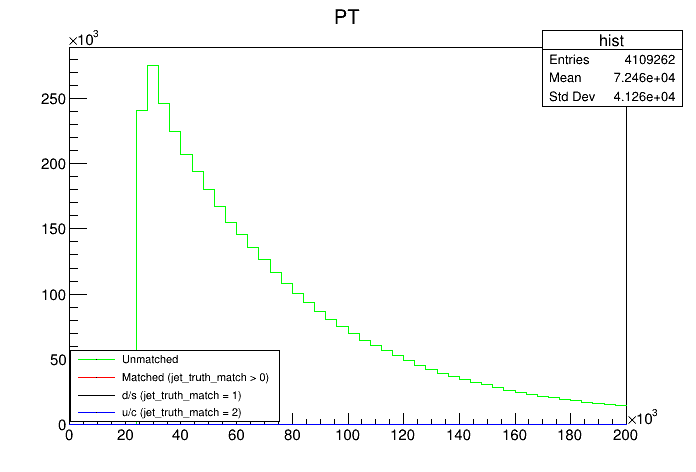

In [21]:
c1 = root.TCanvas()
hist = root.TH1D("hist","PT",50,0, 200000)
hist2 = root.TH1D("hist2","PT",50,0,200000)
hist3 = root.TH1D("hist3","PT",50,0,200000)
hist4 = root.TH1D("hist4","PT",50,0,200000)

hist.SetLineColor(root.kGreen)
hist2.SetLineColor(root.kRed)
hist3.SetLineColor(root.kBlack)
hist4.SetLineColor(root.kBlue)

legend = root.TLegend()
legend.AddEntry(hist,"Unmatched");
legend.AddEntry(hist2,"Matched (jet_truth_match > 0)");
legend.AddEntry(hist3,"d/s (jet_truth_match = 1)");
legend.AddEntry(hist4,"u/c (jet_truth_match = 2)");


tree.Draw("jet_pt >> hist","jet_truth_match==0","")
tree.Draw("jet_pt >> hist2","jet_truth_match != 0","SAME")
tree.Draw("jet_pt >> hist3","jet_truth_match==1","SAME")
tree.Draw("jet_pt >> hist4","jet_truth_match==2","SAME")
legend.Draw()
c1.Draw()

Warning in <TFile::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist4 (Potential memory leak).


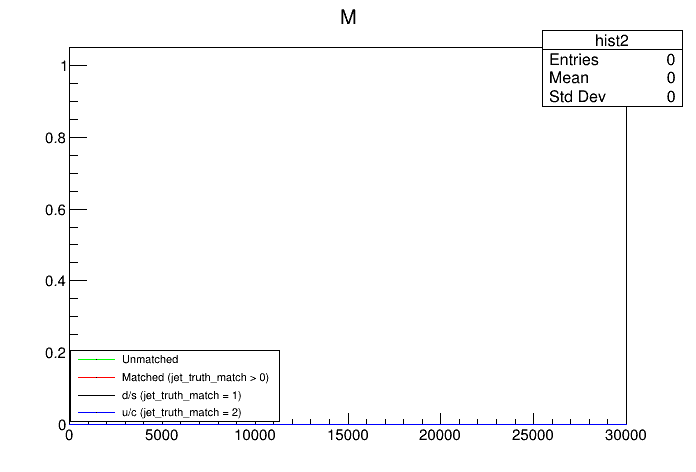

In [22]:
c1 = root.TCanvas()
hist = root.TH1D("hist","M",50,0, 30000)
hist2 = root.TH1D("hist2","M",50,0,30000)
hist3 = root.TH1D("hist3","M",50,0,30000)
hist4 = root.TH1D("hist4","M",50,0,30000)

hist.SetLineColor(root.kGreen)
hist2.SetLineColor(root.kRed)
hist3.SetLineColor(root.kBlack)
hist4.SetLineColor(root.kBlue)

legend = root.TLegend()
legend.AddEntry(hist,"Unmatched");
legend.AddEntry(hist2,"Matched (jet_truth_match > 0)");
legend.AddEntry(hist3,"d/s (jet_truth_match = 1)");
legend.AddEntry(hist4,"u/c (jet_truth_match = 2)");

tree.Draw("jet_m >> hist2","jet_truth_match != 0","")
tree.Draw("jet_m >> hist","jet_truth_match==0","SAME")
tree.Draw("jet_m >> hist3","jet_truth_match==1","SAME")
tree.Draw("jet_m >> hist4","jet_truth_match==2","SAME")
legend.Draw()
c1.Draw()

Warning in <TFile::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist4 (Potential memory leak).


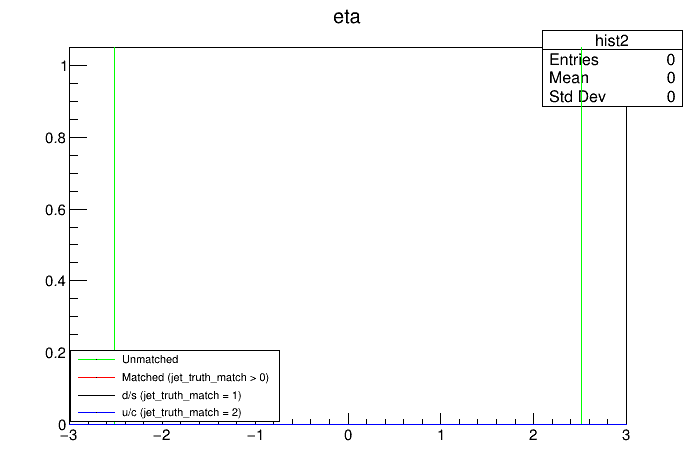

In [23]:
c1 = root.TCanvas()
hist = root.TH1D("hist","eta",50,-3,3)
hist2 = root.TH1D("hist2","eta",50,-3,3)
hist3 = root.TH1D("hist3","eta",50,-3,3)
hist4 = root.TH1D("hist4","eta",50,-3,3)

hist.SetLineColor(root.kGreen)
hist2.SetLineColor(root.kRed)
hist3.SetLineColor(root.kBlack)
hist4.SetLineColor(root.kBlue)

legend = root.TLegend()
legend.AddEntry(hist,"Unmatched");
legend.AddEntry(hist2,"Matched (jet_truth_match > 0)");
legend.AddEntry(hist3,"d/s (jet_truth_match = 1)");
legend.AddEntry(hist4,"u/c (jet_truth_match = 2)");


tree.Draw("jet_eta >> hist2","jet_truth_match != 0","")
tree.Draw("jet_eta >> hist","jet_truth_match==0","SAME")
tree.Draw("jet_eta >> hist3","jet_truth_match==1","SAME")
tree.Draw("jet_eta >> hist4","jet_truth_match==2","SAME")
legend.Draw()
c1.Draw()

Warning in <TFile::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist4 (Potential memory leak).


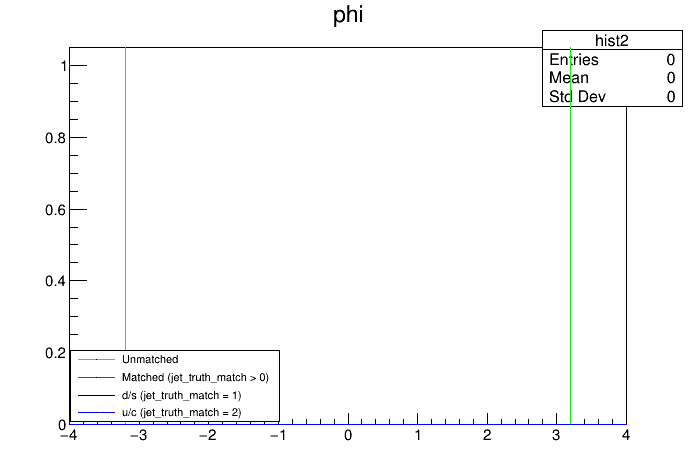

In [24]:
c1 = root.TCanvas()
hist = root.TH1D("hist","phi",50,-4,4)
hist2 = root.TH1D("hist2","phi",50,-4,4)
hist3 = root.TH1D("hist3","phi",50,-4,4)
hist4 = root.TH1D("hist4","phi",50,-4,4)

hist.SetLineColor(root.kGreen)
hist2.SetLineColor(root.kRed)
hist3.SetLineColor(root.kBlack)
hist4.SetLineColor(root.kBlue)

legend = root.TLegend()
legend.AddEntry(hist,"Unmatched");
legend.AddEntry(hist2,"Matched (jet_truth_match > 0)");
legend.AddEntry(hist3,"d/s (jet_truth_match = 1)");
legend.AddEntry(hist4,"u/c (jet_truth_match = 2)");

tree.Draw("jet_phi >> hist2","jet_truth_match != 0","")
tree.Draw("jet_phi >> hist","jet_truth_match==0","SAME")
tree.Draw("jet_phi >> hist3","jet_truth_match==1","SAME")
tree.Draw("jet_phi >> hist4","jet_truth_match==2","SAME")
legend.Draw()
c1.Draw()